# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [82]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files,  test_targets  = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [83]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


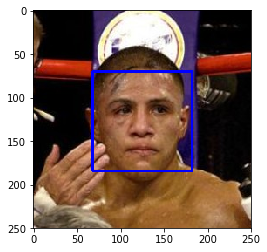

In [84]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [85]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [86]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
test_human=[]
test_dog=[]
for i in range(len(human_files_short)):
    
    test_human.append(face_detector(human_files_short[i]))
#    print(test_human)
   
    test_dog.append(face_detector(dog_files_short[i]))
#    print(test_dog)

n_human=sum(test_human)/len(test_human)*100
n_dog=sum(test_dog)/len(test_dog)*100
print('percentage of correctly classified human faces:',n_human)
print('percentage of misclassified human faces:',n_dog)

percentage of correctly classified human faces: 98.0
percentage of misclassified human faces: 11.0


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Given the state-of-the-art of the problem of "detecting if a human is in the image", I would say that this is no longer a reasonable expectation. I.e. if we consider projects like YOLO (https://pjreddie.com/darknet/yolo/) in which the entire context of the picture is used to detect bounding boxs around multiple humans (objects) in the a picture (using neural network), I would say we do not need a clear image of a "human face" to detect a human in the picture.

In [87]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.



---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [88]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [89]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [90]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [91]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [92]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
test_human=[]
test_dog=[]
for i in range(len(human_files_short)):
    
    test_human.append(dog_detector(human_files_short[i]))
#    print(test_human)
   
    test_dog.append(dog_detector(dog_files_short[i]))
#    print(test_dog)

n_human=sum(test_human)/len(test_human)*100
n_dog=sum(test_dog)/len(test_dog)*100
print('percentage of misclassified dog faces:',n_human)
print('percentage of correctly classified dog faces:',n_dog)


percentage of misclassified dog faces: 1.0
percentage of correctly classified dog faces: 100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [129]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 836/836 [00:05<00:00, 148.63it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I've changed from the architecture abov, (i) by applying a BatchNormalization layer after each MaxPooling2D layer, so that I've groups of layers consisting of conv-pool-batch groups; and  (i) adding 2 additional groups of layers (conv-pool-batch).

Adding the batch normalisation is important as it allows the newtwork to learn more easily scale invariant features. In this layer the parameterisation lambda*H+beta is learned over the normalised activations H (from the previous layer). Its mean is determined solely by beta, and this new parametrization is much easier to learn with gradient descent (Deep Learning Book, Section 8.7.1).

The effect of adding 2 more layers is to learn more features that abstract different characteristics of the dog breeds. As the last 2 layers layers operate on smaller networks, and number of filters was increased.

I've then done 2 experiments:
Experiment 1 - Data augmentation (Test accuracy: 1.0766%)
Experiment 2 - No Data augmentation (Test accuracy: 35.1675%)

Cleary my data augmentation configuration was not optimal for the defautl learning rate and regulariser parameters (the loss, and accuracy improve very slowly in our 10 epochs).
Experiment 2 looks far promising, achieving our goal (accuracy > 1%).



In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
#input
model.add(BatchNormalization(input_shape=(224, 224, 3)))

#conv 16
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#pool 2
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

#conv 32
model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#pool 2
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

#conv 64
model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#pool 2
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

#conv 128
model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#pool 2
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

#conv 256
model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
#pool 2
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

### Compile the Model

In [63]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
##EXPERIMENT 1 - model with data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  

# create and configure augmented image generator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1, #(shift 10% of total width)
        height_shift_range=0.1, #(shift 10% of total height)
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,# randomly flip images horizontally
        fill_mode='nearest')

# fit augmented image generator on data
datagen.fit(train_tensors)
epochs = 10
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/10
334/334 [==============================] - 57s - loss: 4.5631 - acc: 0.0434 - val_loss: 15.8474 - val_acc: 0.0144
Epoch 2/10
334/334 [==============================] - 54s - loss: 4.2465 - acc: 0.0734 - val_loss: 15.9444 - val_acc: 0.0108
Epoch 3/10
334/334 [==============================] - 55s - loss: 4.0182 - acc: 0.1105 - val_loss: 15.9444 - val_acc: 0.0108
Epoch 4/10
334/334 [==============================] - 55s - loss: 3.8129 - acc: 0.1338 - val_loss: 15.8292 - val_acc: 0.0180
Epoch 5/10
334/334 [==============================] - 54s - loss: 3.6256 - acc: 0.1627 - val_loss: 15.8479 - val_acc: 0.0168
Epoch 6/10
334/334 [==============================] - 55s - loss: 3.4499 - acc: 0.1927 - val_loss: 15.9251 - val_acc: 0.0120
Epoch 7/10
334/334 [==============================] - 55s - loss: 3.3045 - acc: 0.2281 - val_loss: 15.9364 - val_acc: 0.0108
Epoch 8/10
308/334 [==========================>...] - ETA: 4s - loss: 3.1657 - acc: 0.2552

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)

print('Data Augmentation Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
### EXPERIMENT 2 model without data augmentation
epochs = 10
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights_old.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

model.load_weights('saved_models/weights_old.best.from_scratch.hdf5')

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)

print('No Data Augmentation Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
import numpy as np
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
#from keras.optimizers import Adam, Adamax
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [103]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import numpy as np
networks=['VGG19','Resnet50','InceptionV3','Xception']
train_dic={}
valid_dic={}
test_dic={}

for i in range(len(networks)):
    
    bottleneck_features = np.load('bottleneck_features/Dog'+networks[i]+'Data.npz')
    train_dic[networks[i]] = bottleneck_features['train']
    valid_dic[networks[i]] = bottleneck_features['valid']
    test_dic[networks[i]] = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



It is hard to know beforehand which network architecture is the best to use for transfer learning. Therefore I've found the best architecture as follows:

1 - For each pre-trained CNN, the last layer was removed, and a GAP layer and a Dense layer were added. This is done as explained in the udacity course, by saving the values of the activations of the pre-trained CNN at the desired layer level (previous to last), and then use these data as inputs of the layers that are addded, and need to be trained.

This allows training only the network parameters from the added layers. For example for the activations of the previous to last layer of the Xception network, are feed to the GAP layer, which in turn outputs 2048 activations. These are used as input of a fully collected (Dense) layer, with 133 hidden units. The total number of parameters to traint is therefore 2048(activations)*133(hidden units)+133(bias terms) = 272517 parameters.

3 - For each network I did a grid search to learn the learning rate, batch size, and optimiser strategy (we used the 'rsmprop', 'Adagrad', and 'Adam') that provided best accuracy in the validation set (where adquate, the momentum was set to the default value).

4 - The configuration with best accuracy on the validation set, for each network, was then used in the test set. That providing best accuracy in the test set was deemed as the best network. These steps can be followed in the next cells.

### (IMPLEMENTATION) Create, Compile and Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [105]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping  
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam, Adagrad,RMSprop
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

grid_results=[]

# this function creates and compiles the model architecture based on the activations pre-saved for the desired transfer learning network.
def create_model(train_data_shape,optimizer='adam',learn_rate=0.001):
    # create model
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_data_shape))
    model.add(Dense(133, activation='softmax'))
    # Compile model
    if optimizer=='Adam':
        optimizer=Adam(lr=learn_rate)
    elif optimizer=='Adagrad':
        optimizer=Adagrad(lr=learn_rate)
    elif optimizer=='rsmprop':
        optimizer=RMSprop(lr=learn_rate)
        
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# this function performs grid search given a transfer-learning network, its activations, and training and validation datasets
def createGridSearch(network,checkpointer,train_data,train_targets,valid_data,valid_targets):
    
    early_stop = EarlyStopping(patience=5)
    
    # create model
    model = KerasClassifier(build_fn=create_model, epochs=20, verbose=1)
    
    # define the grid search parameters
    learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
    
    optimizer  = ['rsmprop', 'Adagrad', 'Adam']
    batch_size = [20,150]
    train_data_shapes=[train_data.shape[1:]]
    
    param_grid = dict(optimizer=optimizer,learn_rate=learn_rate,batch_size=batch_size,train_data_shape=train_data_shapes)
    grid       = GridSearchCV(estimator=model, param_grid=param_grid,#n_jobs=-1,
                        fit_params = {'callbacks':[checkpointer,early_stop],'validation_data': 
                                    (valid_data, valid_targets)})#
    
    # summarize results
    grid.fit(train_data, train_targets)

    
    # summarize results
    print(network[i]," - best: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(network[i],"- %f (%f) with: %r" % (mean, stdev, param))
    return grid


grid_results=[]

for i in range(0,len(networks)):
    
    checkpointer=[]
       
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_grid_'+ networks[i] +'.hdf5', 
                                   verbose=1, save_best_only=True)
    print('Training model',i)
    grid_results.append(createGridSearch(networks[i],checkpointer,train_dic[networks[i]]
                                         ,train_targets,valid_dic[networks[i]],valid_targets))   

Training model 1
Train on 4453 samples, validate on 835 samples
Epoch 1/20


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


4453/4453 [==============================] - 6s - loss: 2.0147 - acc: 0.5205 - val_loss: 0.9985 - val_acc: 0.6922
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 0.4721 - acc: 0.8563 - val_loss: 0.7621 - val_acc: 0.7641
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 0.2513 - acc: 0.9281 - val_loss: 0.7542 - val_acc: 0.7749
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 0.1502 - acc: 0.9555 - val_loss: 0.7089 - val_acc: 0.7868
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.1015 - acc: 0.9710 - val_loss: 0.7559 - val_acc: 0.7976
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.0649 - acc: 0.9829 - val_loss: 0.7508 - val_acc: 0.8012
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.0440 - acc: 0.9874 - val_loss: 0.7590 - val_acc: 0.7916
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0274 - acc: 0.9951 - val_loss: 0.7505 - val_acc: 0.7964
Epoch 9/20


4453/4453 [==============================] - 4s - loss: 3.7932 - acc: 0.2109 - val_loss: 3.0513 - val_acc: 0.3665
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 2.5051 - acc: 0.5122 - val_loss: 2.4692 - val_acc: 0.4982
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 2.0095 - acc: 0.6423 - val_loss: 2.1444 - val_acc: 0.5569
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 1.7090 - acc: 0.7141 - val_loss: 1.9328 - val_acc: 0.6108
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 1.5035 - acc: 0.7575 - val_loss: 1.7785 - val_acc: 0.6395
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 1.3518 - acc: 0.7903 - val_loss: 1.6621 - val_acc: 0.6707
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 1.2341 - acc: 0.8152 - val_loss: 1.5708 - val_acc: 0.6790
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 1.1396 - acc: 0.8325 - val_loss: 1.4954 - val_acc: 0.6934
Epoch 9/20


4453/4453 [==============================] - 1s - loss: 0.8289 - acc: 0.8891 - val_loss: 1.2615 - val_acc: 0.7210
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 0.7944 - acc: 0.8965 - val_loss: 1.2339 - val_acc: 0.7293
Epoch 16/20
4453/4453 [==============================] - 1s - loss: 0.7632 - acc: 0.9016 - val_loss: 1.2092 - val_acc: 0.7329
Epoch 17/20
4453/4453 [==============================] - 1s - loss: 0.7352 - acc: 0.9057 - val_loss: 1.1858 - val_acc: 0.7365
Epoch 18/20
4453/4453 [==============================] - 1s - loss: 0.7095 - acc: 0.9104 - val_loss: 1.1651 - val_acc: 0.7401
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 0.6858 - acc: 0.9144 - val_loss: 1.1460 - val_acc: 0.7425
Epoch 20/20
4440/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 3.8001 - acc: 0.2128 - val_loss: 3.0567 - val_acc: 0.3605
Epoch 2/20
4454/4454

4453/4453 [==============================] - 1s - loss: 0.0389 - acc: 0.9989 - val_loss: 0.6374 - val_acc: 0.8084
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.0303 - acc: 0.9982 - val_loss: 0.6195 - val_acc: 0.8240
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0242 - acc: 0.9991 - val_loss: 0.6294 - val_acc: 0.8216
Epoch 9/20
4453/4453 [==============================] - 1s - loss: 0.0202 - acc: 0.9982 - val_loss: 0.6196 - val_acc: 0.8204
Epoch 10/20
4453/4453 [==============================] - 1s - loss: 0.0180 - acc: 0.9987 - val_loss: 0.6323 - val_acc: 0.8275
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 0.0154 - acc: 0.9987 - val_loss: 0.6553 - val_acc: 0.8156
Epoch 12/20
4453/4453 [==============================] - 1s - loss: 0.0163 - acc: 0.9978 - val_loss: 0.6364 - val_acc: 0.8192
Epoch 13/20
4440/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [

4454/4454 [==============================] - 1s - loss: 0.0393 - acc: 0.9989 - val_loss: 0.6471 - val_acc: 0.7904
Epoch 7/20
4454/4454 [==============================] - 1s - loss: 0.0285 - acc: 0.9993 - val_loss: 0.6530 - val_acc: 0.7856
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 0.0240 - acc: 0.9982 - val_loss: 0.6352 - val_acc: 0.7892
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 0.0180 - acc: 0.9998 - val_loss: 0.6388 - val_acc: 0.7952
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 0.0167 - acc: 0.9991 - val_loss: 0.6385 - val_acc: 0.7868
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 0.0125 - acc: 0.9998 - val_loss: 0.6419 - val_acc: 0.8060
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 0.0123 - acc: 0.9993 - val_loss: 0.6628 - val_acc: 0.7952
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 0.0097 - acc: 0.9996 - val_loss: 0.6577 - val_acc: 0.7940
Epoch 1

4453/4453 [==============================] - 1s - loss: 14.1264 - acc: 0.1197 - val_loss: 14.1951 - val_acc: 0.1150
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 14.1154 - acc: 0.1217 - val_loss: 14.1816 - val_acc: 0.1138
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 14.0944 - acc: 0.1237 - val_loss: 14.2282 - val_acc: 0.1138
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 14.0978 - acc: 0.1231 - val_loss: 14.1960 - val_acc: 0.1126
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 14.0788 - acc: 0.1262 - val_loss: 14.1648 - val_acc: 0.1150
Epoch 9/20
4380/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 14.1877 - acc: 0.0963 - val_loss: 14.3034 - val_acc: 0.0898
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 13.9084 - acc: 0.1302 - val_loss: 14.1096 - val_acc: 0.1126
Epoch 3/20
4

4453/4453 [==============================] - 1s - loss: 0.0785 - acc: 0.9991 - val_loss: 0.6227 - val_acc: 0.8216
Epoch 9/20
4453/4453 [==============================] - 1s - loss: 0.0695 - acc: 0.9989 - val_loss: 0.6244 - val_acc: 0.8156
Epoch 10/20
4453/4453 [==============================] - 1s - loss: 0.0623 - acc: 0.9989 - val_loss: 0.6207 - val_acc: 0.8168
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 0.0566 - acc: 0.9989 - val_loss: 0.6140 - val_acc: 0.8251
Epoch 12/20
4453/4453 [==============================] - 1s - loss: 0.0519 - acc: 0.9993 - val_loss: 0.6137 - val_acc: 0.8228
Epoch 13/20
4453/4453 [==============================] - 1s - loss: 0.0479 - acc: 0.9989 - val_loss: 0.6082 - val_acc: 0.8240
Epoch 14/20
4453/4453 [==============================] - 2s - loss: 0.0446 - acc: 0.9991 - val_loss: 0.6031 - val_acc: 0.8204
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 0.0418 - acc: 0.9989 - val_loss: 0.6025 - val_acc: 0.8263
Epoch

4453/4453 [==============================] - 1s - loss: 0.0334 - acc: 0.9993 - val_loss: 0.6005 - val_acc: 0.8168
Epoch 20/20
4440/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 2.2223 - acc: 0.5352 - val_loss: 1.0294 - val_acc: 0.7102
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 0.4231 - acc: 0.9122 - val_loss: 0.8127 - val_acc: 0.7521
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 0.2495 - acc: 0.9656 - val_loss: 0.7539 - val_acc: 0.7713
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 0.1765 - acc: 0.9841 - val_loss: 0.7139 - val_acc: 0.7940
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 0.1361 - acc: 0.9939 - val_loss: 0.6942 - val_acc: 0.7904
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 0.1105 - acc: 0.9973 - val_loss: 0.6738 - val_acc: 0.7976
Epoch 7/20
4454/4454 [===

4453/4453 [==============================] - 1s - loss: 10.7952 - acc: 0.3245 - val_loss: 11.3446 - val_acc: 0.2862
Epoch 13/20
4453/4453 [==============================] - 1s - loss: 10.6854 - acc: 0.3348 - val_loss: 11.2429 - val_acc: 0.2874
Epoch 14/20
4453/4453 [==============================] - 1s - loss: 10.6942 - acc: 0.3333 - val_loss: 11.3576 - val_acc: 0.2838
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 10.7233 - acc: 0.3303 - val_loss: 11.3246 - val_acc: 0.2874
Epoch 16/20
4420/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 12.9253 - acc: 0.1498 - val_loss: 12.6771 - val_acc: 0.1940
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 12.4051 - acc: 0.2118 - val_loss: 12.7643 - val_acc: 0.1760
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 12.2308 - acc: 0.2264 - val_loss: 12.2655 - val_acc: 0.2192
Epoch 4/

4454/4454 [==============================] - 1s - loss: 11.6092 - acc: 0.2773 - val_loss: 12.0067 - val_acc: 0.2455
Epoch 14/20
4454/4454 [==============================] - 1s - loss: 11.5781 - acc: 0.2784 - val_loss: 12.3539 - val_acc: 0.2168
Epoch 15/20
4380/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.9289 - acc: 0.0083 - val_loss: 16.0409 - val_acc: 0.0048
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 16.0457 - acc: 0.0045 - val_loss: 16.0409 - val_acc: 0.0048
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 16.0457 - acc: 0.0045 - val_loss: 16.0409 - val_acc: 0.0048
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 16.0457 - acc: 0.0045 - val_loss: 16.0409 - val_acc: 0.0048
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 16.0457 - acc: 0.0045 - val_loss: 16.0409 - val_acc: 0.0048
Epoch 6/20

4360/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.9549 - acc: 0.0072 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.8204 - acc: 0.0164 - val_loss: 15.3048 - val_acc: 0.0479
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.0059 - acc: 0.0638 - val_loss: 14.7999 - val_acc: 0.0778
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 14.6901 - acc: 0.0849 - val_loss: 14.6097 - val_acc: 0.0874
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 14.5780 - acc: 0.0925 - val_loss: 14.6115 - val_acc: 0.0862
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 14.4621 - acc: 0.1013 - val_loss: 14.4440 - val_acc: 0.1018
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 14.4578 - acc: 0.1024 - val_loss: 14.4086 - val_acc: 0.1042
Epoch 8/20
4

4454/4454 [==============================] - 1s - loss: 14.0409 - acc: 0.1289 - val_loss: 14.1120 - val_acc: 0.1198
Epoch 19/20
4454/4454 [==============================] - 1s - loss: 14.0409 - acc: 0.1289 - val_loss: 14.1119 - val_acc: 0.1198
Epoch 20/20
4380/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 15.6615 - acc: 0.0234 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.7500 - acc: 0.0225 - val_loss: 15.7706 - val_acc: 0.0216
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.8897 - acc: 0.0139 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.9480 - acc: 0.0106 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.9480 - acc: 0.0106 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 6/20

4340/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 15.8849 - acc: 0.0115 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.9878 - acc: 0.0081 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.9878 - acc: 0.0081 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.9878 - acc: 0.0081 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.9878 - acc: 0.0081 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 15.9878 - acc: 0.0081 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 7/20
4380/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [=======

4360/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.9779 - acc: 0.0056 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.9883 - acc: 0.0079 - val_loss: 15.9217 - val_acc: 0.0108
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.4166 - acc: 0.0409 - val_loss: 15.0917 - val_acc: 0.0611
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 14.9663 - acc: 0.0680 - val_loss: 14.8131 - val_acc: 0.0802
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 14.7030 - acc: 0.0860 - val_loss: 14.6493 - val_acc: 0.0898
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 14.6812 - acc: 0.0874 - val_loss: 14.7288 - val_acc: 0.0862
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 14.6501 - acc: 0.0898 - val_loss: 14.6886 - val_acc: 0.0874
Epoch 8/20
4

4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 7/20
4300/4453 [===========================>..] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 15.9332 - acc: 0.0083 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.9769 - acc: 0.0088 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.9769 - acc: 0.0088 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.9769 - acc: 0.0088 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.9769 - acc: 0.0088 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 6/20
4

4454/4454 [==============================] - 5s - loss: 15.9226 - acc: 0.0090 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 7/20
4260/4454 [===========================>..] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 15.9419 - acc: 0.0079 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4

4453/4453 [==============================] - 1s - loss: 16.0240 - acc: 0.0058 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 16.0240 - acc: 0.0058 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 7/20
4260/4453 [===========================>..] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 15.7300 - acc: 0.0211 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.7598 - acc: 0.0222 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.7598 - acc: 0.0222 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.7598 - acc: 0.0222 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.7598 - acc: 0.0222 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 6/20
4

3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 2.9640 - acc: 0.3717 - val_loss: 1.7038 - val_acc: 0.6299
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 1.0718 - acc: 0.7662 - val_loss: 1.0934 - val_acc: 0.7246
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 0.5797 - acc: 0.8837 - val_loss: 0.8803 - val_acc: 0.7509
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 0.3517 - acc: 0.9347 - val_loss: 0.7875 - val_acc: 0.7641
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 0.2318 - acc: 0.9625 - val_loss: 0.7334 - val_acc: 0.7713
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 0.1511 - acc: 0.9843 - val_loss: 0.6764 - val_acc: 0.7940
Epoch 7/20
4453/4453 [==============================] - 0s - loss: 0.1046 - acc: 0.9897 - val_loss: 0.6532 - val_acc: 0.7916
Epoch 8/20
4453/4453 [====

4454/4454 [==============================] - 0s - loss: 0.0108 - acc: 0.9996 - val_loss: 0.6693 - val_acc: 0.7940
Epoch 15/20
4454/4454 [==============================] - 0s - loss: 0.0083 - acc: 0.9993 - val_loss: 0.6912 - val_acc: 0.7940
Epoch 16/20
4454/4454 [==============================] - 0s - loss: 0.0066 - acc: 0.9996 - val_loss: 0.7141 - val_acc: 0.7916
Epoch 17/20
4454/4454 [==============================] - 0s - loss: 0.0048 - acc: 0.9998 - val_loss: 0.7087 - val_acc: 0.7952
Epoch 18/20
3450/4454 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 4.2890 - acc: 0.1183 - val_loss: 3.6651 - val_acc: 0.2120
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 3.1564 - acc: 0.3634 - val_loss: 3.0705 - val_acc: 0.3892
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 2.6175 - acc: 0.5185 - val_loss: 2.7006 - val_acc: 0.4731
Epoch 4/20
4453/4453 [

4453/4453 [==============================] - 0s - loss: 1.4402 - acc: 0.7867 - val_loss: 1.7561 - val_acc: 0.6407
Epoch 10/20
4453/4453 [==============================] - 0s - loss: 1.3504 - acc: 0.8057 - val_loss: 1.6838 - val_acc: 0.6527
Epoch 11/20
4453/4453 [==============================] - 0s - loss: 1.2729 - acc: 0.8179 - val_loss: 1.6217 - val_acc: 0.6647
Epoch 12/20
4453/4453 [==============================] - 0s - loss: 1.2060 - acc: 0.8289 - val_loss: 1.5669 - val_acc: 0.6671
Epoch 13/20
4453/4453 [==============================] - 0s - loss: 1.1467 - acc: 0.8406 - val_loss: 1.5181 - val_acc: 0.6790
Epoch 14/20
4453/4453 [==============================] - 0s - loss: 1.0944 - acc: 0.8495 - val_loss: 1.4755 - val_acc: 0.6790
Epoch 15/20
4453/4453 [==============================] - 0s - loss: 1.0471 - acc: 0.8563 - val_loss: 1.4374 - val_acc: 0.6886
Epoch 16/20
4453/4453 [==============================] - 0s - loss: 1.0043 - acc: 0.8666 - val_loss: 1.4024 - val_acc: 0.6958
Epoc

4453/4453 [==============================] - 4s - loss: 3.3939 - acc: 0.2935 - val_loss: 1.8265 - val_acc: 0.5952
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 1.0251 - acc: 0.7950 - val_loss: 1.0792 - val_acc: 0.7353
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 0.5425 - acc: 0.9025 - val_loss: 0.8910 - val_acc: 0.7557
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 0.3514 - acc: 0.9560 - val_loss: 0.8096 - val_acc: 0.7760
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 0.2518 - acc: 0.9755 - val_loss: 0.7423 - val_acc: 0.7880
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 0.1882 - acc: 0.9881 - val_loss: 0.7100 - val_acc: 0.8000
Epoch 7/20
4453/4453 [==============================] - 0s - loss: 0.1476 - acc: 0.9921 - val_loss: 0.6769 - val_acc: 0.8048
Epoch 8/20
4453/4453 [==============================] - 0s - loss: 0.1174 - acc: 0.9980 - val_loss: 0.6566 - val_acc: 0.8048
Epoch 9/20


4453/4453 [==============================] - 0s - loss: 0.0484 - acc: 0.9993 - val_loss: 0.6203 - val_acc: 0.8108
Epoch 15/20
4453/4453 [==============================] - 0s - loss: 0.0433 - acc: 0.9996 - val_loss: 0.6223 - val_acc: 0.8120
Epoch 16/20
4453/4453 [==============================] - 0s - loss: 0.0387 - acc: 0.9996 - val_loss: 0.6127 - val_acc: 0.8204
Epoch 17/20
4453/4453 [==============================] - 0s - loss: 0.0351 - acc: 0.9993 - val_loss: 0.6142 - val_acc: 0.8072
Epoch 18/20
4453/4453 [==============================] - 0s - loss: 0.0326 - acc: 0.9993 - val_loss: 0.6103 - val_acc: 0.8108
Epoch 19/20
4453/4453 [==============================] - 0s - loss: 0.0298 - acc: 0.9993 - val_loss: 0.6108 - val_acc: 0.8048
Epoch 20/20
3300/4453 [=====================>........] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 3.4245 - acc: 0.2937 - val_loss: 1.8720 - val_acc: 0.6156
Epoch 2/20
4454/4454

4453/4453 [==============================] - 0s - loss: 12.4348 - acc: 0.2246 - val_loss: 12.6186 - val_acc: 0.2072
Epoch 8/20
3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 13.4569 - acc: 0.1002 - val_loss: 13.1191 - val_acc: 0.1461
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 12.7311 - acc: 0.1848 - val_loss: 12.4906 - val_acc: 0.2024
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 12.4500 - acc: 0.2133 - val_loss: 12.6561 - val_acc: 0.1844
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 12.4315 - acc: 0.2181 - val_loss: 12.4107 - val_acc: 0.2168
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 12.4058 - acc: 0.2223 - val_loss: 12.4797 - val_acc: 0.2084
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 12.3939 - acc: 0.2228 - val_loss: 12.4061 - val_acc: 0.2120
Epoch 7/20
4

4453/4453 [==============================] - 0s - loss: 0.7141 - acc: 0.9562 - val_loss: 1.2317 - val_acc: 0.7725
Epoch 8/20
4453/4453 [==============================] - 0s - loss: 0.6921 - acc: 0.9573 - val_loss: 1.2195 - val_acc: 0.7665
Epoch 9/20
4453/4453 [==============================] - 0s - loss: 0.6413 - acc: 0.9605 - val_loss: 1.1488 - val_acc: 0.7749
Epoch 10/20
4453/4453 [==============================] - 0s - loss: 0.5992 - acc: 0.9654 - val_loss: 1.1363 - val_acc: 0.7784
Epoch 11/20
4453/4453 [==============================] - 0s - loss: 0.5864 - acc: 0.9672 - val_loss: 1.1246 - val_acc: 0.7832
Epoch 12/20
4453/4453 [==============================] - 0s - loss: 0.5775 - acc: 0.9679 - val_loss: 1.1189 - val_acc: 0.7749
Epoch 13/20
4453/4453 [==============================] - 0s - loss: 0.5698 - acc: 0.9686 - val_loss: 1.1151 - val_acc: 0.7820
Epoch 14/20
4453/4453 [==============================] - 0s - loss: 0.5634 - acc: 0.9688 - val_loss: 1.1068 - val_acc: 0.7820
Epoch 

3450/4453 [======================>.......] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 3.7883 - acc: 0.3931 - val_loss: 1.6523 - val_acc: 0.5976
Epoch 2/20
4454/4454 [==============================] - 0s - loss: 0.7782 - acc: 0.8350 - val_loss: 1.0852 - val_acc: 0.7210
Epoch 3/20
4454/4454 [==============================] - 0s - loss: 0.4795 - acc: 0.9243 - val_loss: 0.9487 - val_acc: 0.7497
Epoch 4/20
4454/4454 [==============================] - 0s - loss: 0.3581 - acc: 0.9589 - val_loss: 0.8658 - val_acc: 0.7677
Epoch 5/20
4454/4454 [==============================] - 0s - loss: 0.2875 - acc: 0.9764 - val_loss: 0.8399 - val_acc: 0.7784
Epoch 6/20
4454/4454 [==============================] - 0s - loss: 0.2441 - acc: 0.9838 - val_loss: 0.8125 - val_acc: 0.7880
Epoch 7/20
4454/4454 [==============================] - 0s - loss: 0.2134 - acc: 0.9897 - val_loss: 0.7894 - val_acc: 0.7904
Epoch 8/20
4454/4454 [====

3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 5.0374 - acc: 0.4035 - val_loss: 3.9204 - val_acc: 0.5545
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 2.9865 - acc: 0.7357 - val_loss: 3.5728 - val_acc: 0.6216
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 2.6413 - acc: 0.7959 - val_loss: 3.5031 - val_acc: 0.6263
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 2.5270 - acc: 0.8255 - val_loss: 3.3878 - val_acc: 0.6455
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 2.4919 - acc: 0.8365 - val_loss: 3.3162 - val_acc: 0.6599
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 2.4735 - acc: 0.8437 - val_loss: 3.1762 - val_acc: 0.6802
Epoch 7/20
4453/4453 [==============================] - 0s - loss: 2.4650 - acc: 0.8455 - val_loss: 3.1812 - val_acc: 0.6862
Epoch 8/20
4453/4453 [====

4454/4454 [==============================] - 0s - loss: 4.0171 - acc: 0.7490 - val_loss: 5.0109 - val_acc: 0.5916
Epoch 17/20
3450/4454 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.5197 - acc: 0.0135 - val_loss: 15.7628 - val_acc: 0.0204
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.7405 - acc: 0.0234 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 15.7236 - acc: 0.0245 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 15.7236 - acc: 0.0245 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 15.7236 - acc: 0.0245 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 15.7236 - acc: 0.0245 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 7/20
44

4453/4453 [==============================] - 0s - loss: 15.9914 - acc: 0.0079 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 13/20
4453/4453 [==============================] - 0s - loss: 15.9914 - acc: 0.0079 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 14/20
3450/4453 [======================>.......] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 15.4268 - acc: 0.0200 - val_loss: 15.7702 - val_acc: 0.0192
Epoch 2/20
4454/4454 [==============================] - 0s - loss: 15.7601 - acc: 0.0218 - val_loss: 15.6741 - val_acc: 0.0275
Epoch 3/20
4454/4454 [==============================] - 0s - loss: 15.7064 - acc: 0.0251 - val_loss: 15.8092 - val_acc: 0.0192
Epoch 4/20
4454/4454 [==============================] - 0s - loss: 15.8331 - acc: 0.0175 - val_loss: 15.8092 - val_acc: 0.0192
Epoch 5/20
4454/4454 [==============================] - 0s - loss: 15.7716 - acc: 0.0213 - val_loss: 15.6741 - val_acc: 0.0275
Epoch 6/20

4453/4453 [==============================] - 0s - loss: 15.3073 - acc: 0.0503 - val_loss: 15.3460 - val_acc: 0.0479
Epoch 19/20
4453/4453 [==============================] - 0s - loss: 15.3073 - acc: 0.0503 - val_loss: 15.3460 - val_acc: 0.0479
Epoch 20/20
3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.2678 - acc: 0.0260 - val_loss: 15.5587 - val_acc: 0.0347
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.4755 - acc: 0.0380 - val_loss: 15.4555 - val_acc: 0.0407
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 15.4235 - acc: 0.0429 - val_loss: 15.4425 - val_acc: 0.0419
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 15.4231 - acc: 0.0431 - val_loss: 15.4425 - val_acc: 0.0419
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 15.4231 - acc: 0.0431 - val_loss: 15.4425 - val_acc: 0.0419
Epoch 6/20

4454/4454 [==============================] - 0s - loss: 14.2834 - acc: 0.1138 - val_loss: 14.2985 - val_acc: 0.1114
Epoch 20/20
3450/4454 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 14.7301 - acc: 0.0579 - val_loss: 14.8572 - val_acc: 0.0766
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 14.9579 - acc: 0.0701 - val_loss: 15.1621 - val_acc: 0.0575
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 14.7182 - acc: 0.0849 - val_loss: 14.7620 - val_acc: 0.0826
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 14.4651 - acc: 0.1013 - val_loss: 14.4369 - val_acc: 0.1006
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 14.3592 - acc: 0.1073 - val_loss: 14.6170 - val_acc: 0.0922
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 14.3552 - acc: 0.1082 - val_loss: 14.6385 - val_acc: 0.0886
Epoch 7/20


4453/4453 [==============================] - 0s - loss: 14.3176 - acc: 0.1105 - val_loss: 14.4516 - val_acc: 0.1030
Epoch 12/20
4453/4453 [==============================] - 0s - loss: 14.4128 - acc: 0.1055 - val_loss: 14.5658 - val_acc: 0.0958
Epoch 13/20
4453/4453 [==============================] - 0s - loss: 14.3940 - acc: 0.1062 - val_loss: 14.4975 - val_acc: 0.0994
Epoch 14/20
4453/4453 [==============================] - 0s - loss: 14.3165 - acc: 0.1109 - val_loss: 14.4194 - val_acc: 0.1054
Epoch 15/20
4453/4453 [==============================] - 0s - loss: 14.2475 - acc: 0.1159 - val_loss: 14.4972 - val_acc: 0.1006
Epoch 16/20
4453/4453 [==============================] - 0s - loss: 14.3764 - acc: 0.1073 - val_loss: 14.5429 - val_acc: 0.0970
Epoch 17/20
4453/4453 [==============================] - 0s - loss: 14.4131 - acc: 0.1049 - val_loss: 14.5552 - val_acc: 0.0970
Epoch 18/20
4453/4453 [==============================] - 0s - loss: 14.2785 - acc: 0.1136 - val_loss: 14.4689 - val_

4453/4453 [==============================] - 0s - loss: 16.0095 - acc: 0.0067 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 16.0095 - acc: 0.0067 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 16.0095 - acc: 0.0067 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 16.0095 - acc: 0.0067 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 7/20
3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.5564 - acc: 0.0117 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 4/20
4

4453/4453 [==============================] - 0s - loss: 15.1372 - acc: 0.0609 - val_loss: 15.1529 - val_acc: 0.0599
Epoch 13/20
3450/4453 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.3842 - acc: 0.0222 - val_loss: 15.8804 - val_acc: 0.0120
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.7689 - acc: 0.0209 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 3/20
4453/4453 [==============================] - 0s - loss: 15.7055 - acc: 0.0256 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 4/20
4453/4453 [==============================] - 0s - loss: 15.7055 - acc: 0.0256 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 5/20
4453/4453 [==============================] - 0s - loss: 15.7055 - acc: 0.0256 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 6/20
4453/4453 [==============================] - 0s - loss: 15.7055 - acc: 0.0256 - val_loss: 15.7127 - val_acc: 0.0251
Epoch 7/20


4453/4453 [==============================] - 0s - loss: 14.8722 - acc: 0.0766 - val_loss: 14.8963 - val_acc: 0.0743
Epoch 9/20
4453/4453 [==============================] - 0s - loss: 14.8597 - acc: 0.0775 - val_loss: 14.5932 - val_acc: 0.0946
Epoch 10/20
4453/4453 [==============================] - 0s - loss: 14.4807 - acc: 0.1006 - val_loss: 14.6342 - val_acc: 0.0910
Epoch 11/20
4453/4453 [==============================] - 0s - loss: 14.6541 - acc: 0.0905 - val_loss: 14.8248 - val_acc: 0.0802
Epoch 12/20
4453/4453 [==============================] - 0s - loss: 14.6381 - acc: 0.0914 - val_loss: 14.6042 - val_acc: 0.0934
Epoch 13/20
4453/4453 [==============================] - 0s - loss: 14.5387 - acc: 0.0979 - val_loss: 14.5480 - val_acc: 0.0970
Epoch 14/20
4453/4453 [==============================] - 0s - loss: 14.4640 - acc: 0.1022 - val_loss: 14.4991 - val_acc: 0.0994
Epoch 15/20
4453/4453 [==============================] - 0s - loss: 14.4580 - acc: 0.1026 - val_loss: 14.3619 - val_a

4454/4454 [==============================] - 0s - loss: 15.2811 - acc: 0.0514 - val_loss: 15.5583 - val_acc: 0.0347
Epoch 3/20
4454/4454 [==============================] - 0s - loss: 15.4390 - acc: 0.0418 - val_loss: 15.3846 - val_acc: 0.0455
Epoch 4/20
4454/4454 [==============================] - 0s - loss: 15.0735 - acc: 0.0642 - val_loss: 14.9220 - val_acc: 0.0731
Epoch 5/20
4454/4454 [==============================] - 0s - loss: 14.9687 - acc: 0.0709 - val_loss: 14.8890 - val_acc: 0.0754
Epoch 6/20
4454/4454 [==============================] - 0s - loss: 15.0574 - acc: 0.0651 - val_loss: 15.1345 - val_acc: 0.0599
Epoch 7/20
3450/4454 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.6401 - acc: 0.0081 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.9733 - acc: 0.0090 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4

4454/4454 [==============================] - 0s - loss: 15.9290 - acc: 0.0117 - val_loss: 15.9549 - val_acc: 0.0096
Epoch 6/20
4454/4454 [==============================] - 0s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9549 - val_acc: 0.0096
Epoch 7/20
4454/4454 [==============================] - 0s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9549 - val_acc: 0.0096
Epoch 8/20
4454/4454 [==============================] - 0s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9549 - val_acc: 0.0096
Epoch 9/20
4454/4454 [==============================] - 0s - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9549 - val_acc: 0.0096
Epoch 10/20
3450/4454 [======================>.......] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 4s - loss: 15.3756 - acc: 0.0234 - val_loss: 15.7899 - val_acc: 0.0204
Epoch 2/20
4453/4453 [==============================] - 0s - loss: 15.7357 - acc: 0.0236 - val_loss: 15.9559 - val_acc: 0.0072
Epoch 3/20


4454/4454 [==============================] - 4s - loss: 15.6217 - acc: 0.0090 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 4/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 5/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 6/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 7/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 8/20
4454/4454 [==============================] - 0s - loss: 15.9661 - acc: 0.0094 - val_loss: 15.9637 - val_acc: 0.

3300/4453 [=====================>........] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 4s - loss: 15.4392 - acc: 0.0180 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 2/20
4454/4454 [==============================] - 0s - loss: 15.8351 - acc: 0.0173 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 3/20
4454/4454 [==============================] - 0s - loss: 15.8322 - acc: 0.0177 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 4/20
4454/4454 [==============================] - 0s - loss: 15.8322 - acc: 0.0177 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 5/20
4454/4454 [==============================] - 0s - loss: 15.8322 - acc: 0.0177 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 6/20
4454/4454 [==============================] - 0s - loss: 15.8322 - acc: 0.0177 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 7/20
4454/4454 [==============================] - 0s - loss: 15.8322 - acc: 0.0177 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 8/20
4

6680/6680 [==============================] - 0s - loss: 0.0249 - acc: 0.9990 - val_loss: 0.5469 - val_acc: 0.8407
e  - best: 0.817964 using {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.001, 'batch_size': 150, 'optimizer': 'Adam'}
e - 0.805389 (0.008913) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.001, 'batch_size': 20, 'optimizer': 'rsmprop'}
e - 0.754192 (0.012354) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.001, 'batch_size': 20, 'optimizer': 'Adagrad'}
e - 0.816916 (0.011756) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.001, 'batch_size': 20, 'optimizer': 'Adam'}
e - 0.166766 (0.073005) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.01, 'batch_size': 20, 'optimizer': 'rsmprop'}
e - 0.814222 (0.005646) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.01, 'batch_size': 20, 'optimizer': 'Adagrad'}
e - 0.260928 (0.030052) with: {'train_data_shape': (1, 1, 2048), 'learn_rate': 0.01, 'batch_size': 20, 'optimizer': 'Adam'}
e - 0

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Train on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 1.3704 - acc: 0.6685 - val_loss: 0.6925 - val_acc: 0.7928
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 0.4484 - acc: 0.8556 - val_loss: 0.6904 - val_acc: 0.8156
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 0.3262 - acc: 0.8951 - val_loss: 0.6606 - val_acc: 0.8263
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 0.2376 - acc: 0.9180 - val_loss: 0.6515 - val_acc: 0.8395
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.1847 - acc: 0.9378 - val_loss: 0.6619 - val_acc: 0.8359
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.1442 - acc: 0.9506 - val_loss: 0.7761 - val_acc: 0.8180
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.1150 - acc: 0.9627 - val_loss: 0.6955 - val_acc: 0.8431
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0896 - ac

4453/4453 [==============================] - 6s - loss: 2.7846 - acc: 0.4687 - val_loss: 1.6942 - val_acc: 0.7102
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 1.3079 - acc: 0.7734 - val_loss: 1.1796 - val_acc: 0.7605
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 0.9581 - acc: 0.8235 - val_loss: 0.9775 - val_acc: 0.7844
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 0.7943 - acc: 0.8437 - val_loss: 0.8688 - val_acc: 0.8036
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.6960 - acc: 0.8650 - val_loss: 0.7981 - val_acc: 0.8156
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.6288 - acc: 0.8765 - val_loss: 0.7521 - val_acc: 0.8263
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.5794 - acc: 0.8857 - val_loss: 0.7158 - val_acc: 0.8251
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.5409 - acc: 0.8911 - val_loss: 0.6883 - val_acc: 0.8275
Epoch 9/20


4453/4453 [==============================] - 1s - loss: 0.5186 - acc: 0.8900 - val_loss: 0.6600 - val_acc: 0.8323
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 0.4951 - acc: 0.8947 - val_loss: 0.6433 - val_acc: 0.8371
Epoch 12/20
4453/4453 [==============================] - 1s - loss: 0.4752 - acc: 0.8969 - val_loss: 0.6302 - val_acc: 0.8419
Epoch 13/20
4453/4453 [==============================] - 1s - loss: 0.4571 - acc: 0.9055 - val_loss: 0.6190 - val_acc: 0.8443
Epoch 14/20
4453/4453 [==============================] - 1s - loss: 0.4412 - acc: 0.9070 - val_loss: 0.6088 - val_acc: 0.8443
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 0.4270 - acc: 0.9099 - val_loss: 0.6007 - val_acc: 0.8491
Epoch 16/20
4453/4453 [==============================] - 1s - loss: 0.4141 - acc: 0.9129 - val_loss: 0.5924 - val_acc: 0.8503
Epoch 17/20
4453/4453 [==============================] - 1s - loss: 0.4022 - acc: 0.9133 - val_loss: 0.5853 - val_acc: 0.8527
Epoc

4453/4453 [==============================] - 1s - loss: 0.2077 - acc: 0.9335 - val_loss: 0.6217 - val_acc: 0.8275
Epoch 4/20
4453/4453 [==============================] - 4s - loss: 0.1315 - acc: 0.9629 - val_loss: 0.5295 - val_acc: 0.8467
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.0806 - acc: 0.9791 - val_loss: 0.5634 - val_acc: 0.8467
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.0521 - acc: 0.9899 - val_loss: 0.5368 - val_acc: 0.8455
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.0364 - acc: 0.9942 - val_loss: 0.5238 - val_acc: 0.8599
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0272 - acc: 0.9951 - val_loss: 0.5764 - val_acc: 0.8443
Epoch 9/20
4453/4453 [==============================] - 1s - loss: 0.0269 - acc: 0.9953 - val_loss: 0.5481 - val_acc: 0.8623
Epoch 10/20
4453/4453 [==============================] - 1s - loss: 0.0261 - acc: 0.9953 - val_loss: 0.5317 - val_acc: 0.8467
Epoch 11/2

4454/4454 [==============================] - 1s - loss: 0.0640 - acc: 0.9859 - val_loss: 0.6445 - val_acc: 0.8311
Epoch 7/20
4454/4454 [==============================] - 1s - loss: 0.0526 - acc: 0.9890 - val_loss: 0.6004 - val_acc: 0.8419
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 0.0287 - acc: 0.9966 - val_loss: 0.6176 - val_acc: 0.8455
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 0.0233 - acc: 0.9971 - val_loss: 0.6132 - val_acc: 0.8479
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 0.0235 - acc: 0.9939 - val_loss: 0.6411 - val_acc: 0.8491
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 0.0224 - acc: 0.9962 - val_loss: 0.6217 - val_acc: 0.8539
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 0.0126 - acc: 0.9989 - val_loss: 0.6529 - val_acc: 0.8491
Epoch 13/20
4400/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [

4453/4453 [==============================] - 1s - loss: 14.1017 - acc: 0.1242 - val_loss: 14.1320 - val_acc: 0.1210
Epoch 14/20
4453/4453 [==============================] - 1s - loss: 14.0976 - acc: 0.1246 - val_loss: 14.1033 - val_acc: 0.1234
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 13.7297 - acc: 0.1453 - val_loss: 13.6509 - val_acc: 0.1317
Epoch 16/20
4453/4453 [==============================] - 1s - loss: 13.2116 - acc: 0.1774 - val_loss: 13.2087 - val_acc: 0.1737
Epoch 17/20
4453/4453 [==============================] - 1s - loss: 13.0249 - acc: 0.1884 - val_loss: 12.9011 - val_acc: 0.1952
Epoch 18/20
4453/4453 [==============================] - 1s - loss: 12.6016 - acc: 0.2109 - val_loss: 12.2036 - val_acc: 0.2323
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 12.0564 - acc: 0.2450 - val_loss: 11.9566 - val_acc: 0.2491
Epoch 20/20
4360/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch

4453/4453 [==============================] - 1s - loss: 0.1256 - acc: 0.9762 - val_loss: 0.5189 - val_acc: 0.8503
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.1029 - acc: 0.9856 - val_loss: 0.5050 - val_acc: 0.8551
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.0882 - acc: 0.9885 - val_loss: 0.4914 - val_acc: 0.8527
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0774 - acc: 0.9937 - val_loss: 0.4888 - val_acc: 0.8671
Epoch 9/20
4453/4453 [==============================] - 1s - loss: 0.0690 - acc: 0.9935 - val_loss: 0.4933 - val_acc: 0.8599
Epoch 10/20
4453/4453 [==============================] - 1s - loss: 0.0615 - acc: 0.9955 - val_loss: 0.5035 - val_acc: 0.8563
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 0.0567 - acc: 0.9957 - val_loss: 0.4953 - val_acc: 0.8671
Epoch 12/20
4453/4453 [==============================] - 1s - loss: 0.0525 - acc: 0.9957 - val_loss: 0.4930 - val_acc: 0.8683
Epoch 13

4454/4454 [==============================] - 1s - loss: 0.0811 - acc: 0.9919 - val_loss: 0.5069 - val_acc: 0.8503
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 0.0721 - acc: 0.9942 - val_loss: 0.5165 - val_acc: 0.8515
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 0.0653 - acc: 0.9957 - val_loss: 0.5235 - val_acc: 0.8479
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 0.0594 - acc: 0.9960 - val_loss: 0.5157 - val_acc: 0.8527
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 0.0548 - acc: 0.9969 - val_loss: 0.5204 - val_acc: 0.8479
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 0.0504 - acc: 0.9978 - val_loss: 0.5195 - val_acc: 0.8503
Epoch 14/20
4360/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 12.0599 - acc: 0.2190 - val_loss: 11.9009 - val_acc: 0.2467
Epoch 2/20
4453/445

4454/4454 [==============================] - 1s - loss: 12.6788 - acc: 0.2101 - val_loss: 12.7535 - val_acc: 0.2024
Epoch 7/20
4440/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.8965 - acc: 0.0106 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 16.0131 - acc: 0.0065 - val_loss: 16.0023 - val_acc: 0.0072
Epoch 7/20
4

4320/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.1620 - acc: 0.0525 - val_loss: 14.7301 - val_acc: 0.0838
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 14.2846 - acc: 0.1100 - val_loss: 14.1088 - val_acc: 0.1210
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 14.0315 - acc: 0.1264 - val_loss: 14.0020 - val_acc: 0.1293
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 14.0010 - acc: 0.1298 - val_loss: 13.9650 - val_acc: 0.1317
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 13.9641 - acc: 0.1332 - val_loss: 13.9812 - val_acc: 0.1305
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 13.9669 - acc: 0.1327 - val_loss: 13.9772 - val_acc: 0.1317
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 13.9646 - acc: 0.1332 - val_loss: 13.9433 - val_acc: 0.1317
Epoch 8/20
4

4453/4453 [==============================] - 1s - loss: 15.1270 - acc: 0.0613 - val_loss: 15.7151 - val_acc: 0.0240
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.3833 - acc: 0.0451 - val_loss: 15.1304 - val_acc: 0.0611
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 15.1517 - acc: 0.0600 - val_loss: 15.1915 - val_acc: 0.0575
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 15.1552 - acc: 0.0595 - val_loss: 15.3460 - val_acc: 0.0479
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 15.5355 - acc: 0.0357 - val_loss: 15.5412 - val_acc: 0.0347
Epoch 9/20
4380/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 6s - loss: 15.9099 - acc: 0.0092 - val_loss: 16.0216 - val_acc: 0.0060
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 16.0240 - acc: 0.0058 - val_loss: 16.0216 - val_acc: 0.0060
Epoch 3/20
4

4454/4454 [==============================] - 1s - loss: 15.8141 - acc: 0.0189 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 7/20
4320/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.8898 - acc: 0.0110 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.5453 - acc: 0.0335 - val_loss: 15.4188 - val_acc: 0.0431
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.0712 - acc: 0.0631 - val_loss: 14.5932 - val_acc: 0.0946
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 14.3610 - acc: 0.1080 - val_loss: 14.3089 - val_acc: 0.1102
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 14.1149 - acc: 0.1233 - val_loss: 14.2121 - val_acc: 0.1174
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 14.1027 - acc: 0.1249 - val_loss: 14.1856 - val_acc: 0.1198
Epoch 7/20
4

4454/4454 [==============================] - 1s - loss: 15.9733 - acc: 0.0090 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 15.9733 - acc: 0.0090 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 15.9733 - acc: 0.0090 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 15.9733 - acc: 0.0090 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 7/20
4300/4454 [===========================>..] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.8328 - acc: 0.0144 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.9588 - acc: 0.0099 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.9588 - acc: 0.0099 - val_loss: 15.9830 - val_acc: 0.0084
Epoch 4/20
4

4360/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.9250 - acc: 0.0090 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.9697 - acc: 0.0092 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.9697 - acc: 0.0092 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.9697 - acc: 0.0092 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.9697 - acc: 0.0092 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 15.9697 - acc: 0.0092 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 7/20
4400/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [=======

4453/4453 [==============================] - 1s - loss: 14.1852 - acc: 0.1199 - val_loss: 14.1878 - val_acc: 0.1198
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 14.1852 - acc: 0.1199 - val_loss: 14.1878 - val_acc: 0.1198
Epoch 12/20
4360/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 6s - loss: 15.8838 - acc: 0.0110 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 15.9842 - acc: 0.0083 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 6/20

4453/4453 [==============================] - 5s - loss: 1.9972 - acc: 0.5810 - val_loss: 0.9165 - val_acc: 0.7593
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 0.6000 - acc: 0.8318 - val_loss: 0.6694 - val_acc: 0.7928
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 0.3911 - acc: 0.8875 - val_loss: 0.5911 - val_acc: 0.8108
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 0.2830 - acc: 0.9189 - val_loss: 0.5264 - val_acc: 0.8455
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.2092 - acc: 0.9389 - val_loss: 0.5456 - val_acc: 0.8467
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.1627 - acc: 0.9540 - val_loss: 0.5482 - val_acc: 0.8347
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.1247 - acc: 0.9672 - val_loss: 0.5565 - val_acc: 0.8323
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.0965 - acc: 0.9757 - val_loss: 0.5649 - val_acc: 0.8323
Epoch 9/20


4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 5s - loss: 3.5664 - acc: 0.3245 - val_loss: 2.5415 - val_acc: 0.5641
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 2.0532 - acc: 0.6544 - val_loss: 1.7812 - val_acc: 0.6874
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 1.4895 - acc: 0.7449 - val_loss: 1.4128 - val_acc: 0.7389
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 1.1946 - acc: 0.7896 - val_loss: 1.2054 - val_acc: 0.7689
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 1.0173 - acc: 0.8120 - val_loss: 1.0704 - val_acc: 0.7820
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.8980 - acc: 0.8347 - val_loss: 0.9810 - val_acc: 0.7976
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.8117 - acc: 0.8495 - val_loss: 0.9138 - val_acc: 0.8072
Epoch 8/20
4453/4453 [====

4453/4453 [==============================] - 1s - loss: 0.6059 - acc: 0.8850 - val_loss: 0.7468 - val_acc: 0.8096
Epoch 13/20
4453/4453 [==============================] - 1s - loss: 0.5798 - acc: 0.8879 - val_loss: 0.7275 - val_acc: 0.8168
Epoch 14/20
4453/4453 [==============================] - 1s - loss: 0.5565 - acc: 0.8915 - val_loss: 0.7105 - val_acc: 0.8216
Epoch 15/20
4453/4453 [==============================] - 1s - loss: 0.5368 - acc: 0.8954 - val_loss: 0.6958 - val_acc: 0.8228
Epoch 16/20
4453/4453 [==============================] - 1s - loss: 0.5184 - acc: 0.8994 - val_loss: 0.6829 - val_acc: 0.8263
Epoch 17/20
4453/4453 [==============================] - 1s - loss: 0.5024 - acc: 0.9039 - val_loss: 0.6716 - val_acc: 0.8275
Epoch 18/20
4453/4453 [==============================] - 1s - loss: 0.4875 - acc: 0.9043 - val_loss: 0.6608 - val_acc: 0.8323
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 0.4738 - acc: 0.9073 - val_loss: 0.6511 - val_acc: 0.8311
Epoc

4453/4453 [==============================] - 1s - loss: 0.2605 - acc: 0.9329 - val_loss: 0.5154 - val_acc: 0.8575
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 0.2034 - acc: 0.9506 - val_loss: 0.5112 - val_acc: 0.8527
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 0.1632 - acc: 0.9663 - val_loss: 0.5074 - val_acc: 0.8527
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 0.1299 - acc: 0.9782 - val_loss: 0.4893 - val_acc: 0.8599
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 0.1064 - acc: 0.9847 - val_loss: 0.4908 - val_acc: 0.8611
Epoch 9/20
4453/4453 [==============================] - 3s - loss: 0.0886 - acc: 0.9903 - val_loss: 0.4881 - val_acc: 0.8599
Epoch 10/20
4453/4453 [==============================] - 1s - loss: 0.0805 - acc: 0.9912 - val_loss: 0.5026 - val_acc: 0.8551
Epoch 11/20
4453/4453 [==============================] - 1s - loss: 0.0696 - acc: 0.9930 - val_loss: 0.4833 - val_acc: 0.8563
Epoch 12/

4454/4454 [==============================] - 1s - loss: 0.2685 - acc: 0.9297 - val_loss: 0.5226 - val_acc: 0.8383
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 0.2190 - acc: 0.9470 - val_loss: 0.5168 - val_acc: 0.8503
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 0.1770 - acc: 0.9605 - val_loss: 0.5202 - val_acc: 0.8383
Epoch 7/20
4454/4454 [==============================] - 1s - loss: 0.1400 - acc: 0.9764 - val_loss: 0.5200 - val_acc: 0.8383
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 0.1172 - acc: 0.9838 - val_loss: 0.4866 - val_acc: 0.8599
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 0.0987 - acc: 0.9877 - val_loss: 0.5002 - val_acc: 0.8611
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 0.0849 - acc: 0.9919 - val_loss: 0.5098 - val_acc: 0.8491
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 0.0722 - acc: 0.9935 - val_loss: 0.4993 - val_acc: 0.8527
Epoch 12/

4453/4453 [==============================] - 1s - loss: 9.8633 - acc: 0.3829 - val_loss: 10.1505 - val_acc: 0.3545
Epoch 10/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 6s - loss: 11.0045 - acc: 0.2485 - val_loss: 10.5559 - val_acc: 0.3114
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 10.1265 - acc: 0.3516 - val_loss: 10.5282 - val_acc: 0.3222
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 10.0260 - acc: 0.3619 - val_loss: 10.3343 - val_acc: 0.3341
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 9.9918 - acc: 0.3682 - val_loss: 10.2889 - val_acc: 0.3437
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 9.9662 - acc: 0.3740 - val_loss: 10.4108 - val_acc: 0.3401
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 9.9513 - acc: 0.3745 - val_loss: 10.2071 - val_acc: 0.3569
Epoch 7/20
4454

4453/4453 [==============================] - 1s - loss: 0.4064 - acc: 0.9746 - val_loss: 0.8094 - val_acc: 0.8503
Epoch 16/20
4453/4453 [==============================] - 1s - loss: 0.4022 - acc: 0.9760 - val_loss: 0.8066 - val_acc: 0.8431
Epoch 17/20
4453/4453 [==============================] - 1s - loss: 0.3986 - acc: 0.9769 - val_loss: 0.8139 - val_acc: 0.8479
Epoch 18/20
4453/4453 [==============================] - 1s - loss: 0.3957 - acc: 0.9753 - val_loss: 0.8091 - val_acc: 0.8467
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 0.3932 - acc: 0.9766 - val_loss: 0.8095 - val_acc: 0.8455
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 4.0411 - acc: 0.5183 - val_loss: 2.1993 - val_acc: 0.7246
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 1.7369 - acc: 0.7995 - val_loss: 1.6979 - val_acc: 0.7593
Epoch 3/20
4453/4453 

4454/4454 [==============================] - 1s - loss: 1.6310 - acc: 0.8920 - val_loss: 2.0145 - val_acc: 0.7796
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 1.6217 - acc: 0.8927 - val_loss: 2.0088 - val_acc: 0.7844
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 1.5926 - acc: 0.8913 - val_loss: 1.9085 - val_acc: 0.7856
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 1.5290 - acc: 0.8972 - val_loss: 1.9085 - val_acc: 0.7868
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 1.5171 - acc: 0.9037 - val_loss: 1.9021 - val_acc: 0.7844
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 1.5099 - acc: 0.9044 - val_loss: 1.8986 - val_acc: 0.7856
Epoch 14/20
4454/4454 [==============================] - 1s - loss: 1.5037 - acc: 0.9064 - val_loss: 1.8974 - val_acc: 0.7892
Epoch 15/20
4454/4454 [==============================] - 1s - loss: 1.5001 - acc: 0.9062 - val_loss: 1.8975 - val_acc: 0.7868
Epoch

4454/4454 [==============================] - 6s - loss: 4.1510 - acc: 0.5375 - val_loss: 3.2187 - val_acc: 0.6886
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 2.5479 - acc: 0.7544 - val_loss: 3.0313 - val_acc: 0.7126
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 2.1367 - acc: 0.8080 - val_loss: 3.0466 - val_acc: 0.7162
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 1.9757 - acc: 0.8339 - val_loss: 2.8575 - val_acc: 0.7257
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 1.9069 - acc: 0.8460 - val_loss: 2.8853 - val_acc: 0.7281
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 1.9242 - acc: 0.8489 - val_loss: 2.9411 - val_acc: 0.7365
Epoch 7/20
4454/4454 [==============================] - 1s - loss: 1.8276 - acc: 0.8608 - val_loss: 2.8231 - val_acc: 0.7377
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 1.7986 - acc: 0.8673 - val_loss: 2.9609 - val_acc: 0.7353
Epoch 9/20


4453/4453 [==============================] - 1s - loss: 15.1241 - acc: 0.0615 - val_loss: 15.1143 - val_acc: 0.0623
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.0937 - acc: 0.0636 - val_loss: 15.1143 - val_acc: 0.0623
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.0937 - acc: 0.0636 - val_loss: 15.1143 - val_acc: 0.0623
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 15.0937 - acc: 0.0636 - val_loss: 15.1143 - val_acc: 0.0623
Epoch 7/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 6s - loss: 15.2259 - acc: 0.0317 - val_loss: 15.6206 - val_acc: 0.0299
Epoch 2/20
4454/4454 [==============================] - 1s - loss: 15.6029 - acc: 0.0314 - val_loss: 15.4476 - val_acc: 0.0407
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 15.4039 - acc: 0.0440 - val_loss: 15.3763 - val_acc: 0.0455
Epoch 4/20
4

4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 13.6148 - acc: 0.1222 - val_loss: 12.8689 - val_acc: 0.1976
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 12.8006 - acc: 0.2005 - val_loss: 12.7377 - val_acc: 0.2024
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 12.2207 - acc: 0.2378 - val_loss: 11.9980 - val_acc: 0.2491
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 11.8279 - acc: 0.2605 - val_loss: 11.7959 - val_acc: 0.2575
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 11.4164 - acc: 0.2872 - val_loss: 11.5772 - val_acc: 0.2766
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 11.3915 - acc: 0.2915 - val_loss: 11.3604 - val_acc: 0.2862
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 11.1959 - acc: 0.3005 - val_loss: 11.3097 - val_acc: 0.2946
Epoch 8/20
4

4454/4454 [==============================] - 1s - loss: 14.2399 - acc: 0.1165 - val_loss: 14.2787 - val_acc: 0.1126
Epoch 13/20
4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 12.2631 - acc: 0.2066 - val_loss: 12.0833 - val_acc: 0.2479
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 12.0951 - acc: 0.2457 - val_loss: 12.1470 - val_acc: 0.2443
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 12.3839 - acc: 0.2277 - val_loss: 12.3441 - val_acc: 0.2299
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 12.5235 - acc: 0.2201 - val_loss: 12.5506 - val_acc: 0.2192
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 12.2063 - acc: 0.2405 - val_loss: 12.3371 - val_acc: 0.2335
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 12.2592 - acc: 0.2378 - val_loss: 12.4514 - val_acc: 0.2263
Epoch 7/20


4454/4454 [==============================] - 1s - loss: 12.5318 - acc: 0.2214 - val_loss: 12.9928 - val_acc: 0.1916
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 12.6680 - acc: 0.2133 - val_loss: 12.7565 - val_acc: 0.2084
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 12.5449 - acc: 0.2209 - val_loss: 12.6678 - val_acc: 0.2120
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 12.4522 - acc: 0.2256 - val_loss: 12.9469 - val_acc: 0.1952
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 12.4978 - acc: 0.2238 - val_loss: 12.6887 - val_acc: 0.2120
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 12.3770 - acc: 0.2317 - val_loss: 12.3540 - val_acc: 0.2335
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 12.3309 - acc: 0.2348 - val_loss: 12.5177 - val_acc: 0.2228
Epoch 14/20
4454/4454 [==============================] - 1s - loss: 12.2800 - acc: 0.2380 - val_loss: 12.4036 - val_ac

4453/4453 [==============================] - 1s - loss: 14.8806 - acc: 0.0759 - val_loss: 14.6704 - val_acc: 0.0898
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 14.7869 - acc: 0.0824 - val_loss: 14.6897 - val_acc: 0.0886
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 14.7730 - acc: 0.0833 - val_loss: 14.6897 - val_acc: 0.0886
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 14.7558 - acc: 0.0842 - val_loss: 14.7090 - val_acc: 0.0874
Epoch 7/20
4453/4453 [==============================] - 1s - loss: 14.8459 - acc: 0.0786 - val_loss: 14.9406 - val_acc: 0.0731
Epoch 8/20
4453/4453 [==============================] - 1s - loss: 14.8160 - acc: 0.0802 - val_loss: 14.7453 - val_acc: 0.0850
Epoch 9/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 6s - loss: 15.3866 - acc: 0.0225 - val_loss: 15.8479 - val_acc: 0.0168
Epoch 2/20
4

4453/4453 [==============================] - 1s - loss: 11.1252 - acc: 0.3095 - val_loss: 11.4776 - val_acc: 0.2838
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 11.1254 - acc: 0.3095 - val_loss: 11.4844 - val_acc: 0.2826
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 13.9789 - acc: 0.1022 - val_loss: 14.4705 - val_acc: 0.0934
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 13.1084 - acc: 0.1808 - val_loss: 12.7848 - val_acc: 0.2048
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 12.5911 - acc: 0.2140 - val_loss: 12.5953 - val_acc: 0.2108
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 12.2015 - acc: 0.2396 - val_loss: 12.2827 - val_acc: 0.2335
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 12.1596 - acc: 0.2414 - val_loss: 12.1111 - val_acc: 0.2455
Epoch 6/20

4454/4454 [==============================] - 1s - loss: 13.1851 - acc: 0.1798 - val_loss: 13.3276 - val_acc: 0.1689
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 13.1552 - acc: 0.1830 - val_loss: 13.2827 - val_acc: 0.1737
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 13.1583 - acc: 0.1821 - val_loss: 13.3640 - val_acc: 0.1689
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 13.1506 - acc: 0.1828 - val_loss: 13.3188 - val_acc: 0.1713
Epoch 14/20
4454/4454 [==============================] - 1s - loss: 13.1140 - acc: 0.1852 - val_loss: 13.2899 - val_acc: 0.1713
Epoch 15/20
4454/4454 [==============================] - 1s - loss: 13.1272 - acc: 0.1841 - val_loss: 13.2697 - val_acc: 0.1725
Epoch 16/20
4454/4454 [==============================] - 1s - loss: 13.1091 - acc: 0.1861 - val_loss: 13.2412 - val_acc: 0.1772
Epoch 17/20
4454/4454 [==============================] - 1s - loss: 13.1023 - acc: 0.1866 - val_loss: 13.2717 - val_

4454/4454 [==============================] - 1s - loss: 12.4473 - acc: 0.2252 - val_loss: 12.5241 - val_acc: 0.2228
Epoch 3/20
4454/4454 [==============================] - 1s - loss: 12.2113 - acc: 0.2409 - val_loss: 12.4445 - val_acc: 0.2263
Epoch 4/20
4454/4454 [==============================] - 1s - loss: 12.4109 - acc: 0.2288 - val_loss: 12.6230 - val_acc: 0.2132
Epoch 5/20
4454/4454 [==============================] - 1s - loss: 12.2996 - acc: 0.2355 - val_loss: 12.0824 - val_acc: 0.2479
Epoch 6/20
4454/4454 [==============================] - 1s - loss: 12.1896 - acc: 0.2425 - val_loss: 12.8488 - val_acc: 0.2012
Epoch 7/20
4454/4454 [==============================] - 1s - loss: 12.6426 - acc: 0.2140 - val_loss: 12.6562 - val_acc: 0.2144
Epoch 8/20
4454/4454 [==============================] - 1s - loss: 12.2625 - acc: 0.2382 - val_loss: 12.3461 - val_acc: 0.2311
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 12.2611 - acc: 0.2382 - val_loss: 12.0208 - val_acc: 0.

4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 15.3507 - acc: 0.0245 - val_loss: 15.7797 - val_acc: 0.0204
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 15.6052 - acc: 0.0314 - val_loss: 15.9637 - val_acc: 0.0096
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 15.9335 - acc: 0.0115 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 15.7996 - acc: 0.0198 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 15.7996 - acc: 0.0198 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 6/20
4453/4453 [==============================] - 1s - loss: 15.7996 - acc: 0.0198 - val_loss: 15.8285 - val_acc: 0.0180
Epoch 7/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [=======

4453/4453 [==============================] - 1s - loss: 11.1918 - acc: 0.3043 - val_loss: 11.1803 - val_acc: 0.3018
Epoch 19/20
4453/4453 [==============================] - 1s - loss: 11.0991 - acc: 0.3099 - val_loss: 11.0641 - val_acc: 0.3102
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 6s - loss: 13.9332 - acc: 0.1080 - val_loss: 13.5192 - val_acc: 0.1593
Epoch 2/20
4453/4453 [==============================] - 1s - loss: 12.9144 - acc: 0.1947 - val_loss: 12.6165 - val_acc: 0.2144
Epoch 3/20
4453/4453 [==============================] - 1s - loss: 12.4327 - acc: 0.2257 - val_loss: 12.5320 - val_acc: 0.2156
Epoch 4/20
4453/4453 [==============================] - 1s - loss: 12.1071 - acc: 0.2464 - val_loss: 12.1757 - val_acc: 0.2395
Epoch 5/20
4453/4453 [==============================] - 1s - loss: 11.5110 - acc: 0.2818 - val_loss: 12.0727 - val_acc: 0.2431
Epoch 6/20

4454/4454 [==============================] - 1s - loss: 13.3588 - acc: 0.1706 - val_loss: 13.4177 - val_acc: 0.1665
Epoch 13/20
4454/4454 [==============================] - 1s - loss: 13.3395 - acc: 0.1713 - val_loss: 13.4491 - val_acc: 0.1641
Epoch 14/20
4454/4454 [==============================] - 1s - loss: 13.3396 - acc: 0.1709 - val_loss: 13.4694 - val_acc: 0.1629
Epoch 15/20
4454/4454 [==============================] - 1s - loss: 13.3246 - acc: 0.1720 - val_loss: 13.3405 - val_acc: 0.1713
Epoch 16/20
4454/4454 [==============================] - 1s - loss: 13.2153 - acc: 0.1780 - val_loss: 13.2673 - val_acc: 0.1749
Epoch 17/20
4454/4454 [==============================] - 1s - loss: 13.1732 - acc: 0.1816 - val_loss: 13.2382 - val_acc: 0.1760
Epoch 18/20
4454/4454 [==============================] - 1s - loss: 13.1558 - acc: 0.1832 - val_loss: 13.3130 - val_acc: 0.1713
Epoch 19/20
4454/4454 [==============================] - 1s - loss: 13.1457 - acc: 0.1841 - val_loss: 13.3023 - val_

4454/4454 [==============================] - 1s - loss: 13.0707 - acc: 0.1888 - val_loss: 13.2033 - val_acc: 0.1808
Epoch 9/20
4454/4454 [==============================] - 1s - loss: 13.1883 - acc: 0.1810 - val_loss: 13.2450 - val_acc: 0.1772
Epoch 10/20
4454/4454 [==============================] - 1s - loss: 14.0947 - acc: 0.1248 - val_loss: 13.9175 - val_acc: 0.1353
Epoch 11/20
4454/4454 [==============================] - 1s - loss: 13.5877 - acc: 0.1563 - val_loss: 13.5152 - val_acc: 0.1605
Epoch 12/20
4454/4454 [==============================] - 1s - loss: 13.4688 - acc: 0.1641 - val_loss: 13.5839 - val_acc: 0.1557
Epoch 13/20
4350/4454 [============================>.] - ETA: 0sTrain on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 6s - loss: 1.8953 - acc: 0.5856 - val_loss: 0.6087 - val_acc: 0.8168
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4692 - acc: 0.8617 - val_loss: 0.5631 - val_acc: 0.8311
Epoch 3/20
6

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Train on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 10s - loss: 1.3106 - acc: 0.6939 - val_loss: 0.5624 - val_acc: 0.8180
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 0.3969 - acc: 0.8686 - val_loss: 0.5310 - val_acc: 0.8359
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 0.2993 - acc: 0.9034 - val_loss: 0.5163 - val_acc: 0.8443
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 0.2445 - acc: 0.9198 - val_loss: 0.5277 - val_acc: 0.8455
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 0.2059 - acc: 0.9362 - val_loss: 0.5308 - val_acc: 0.8575
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 0.1745 - acc: 0.9466 - val_loss: 0.5252 - val_acc: 0.8455
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 0.1524 - acc: 0.9508 - val_loss: 0.5480 - val_acc: 0.8407
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 0.1282 - a

4453/4453 [==============================] - 7s - loss: 3.2034 - acc: 0.4680 - val_loss: 2.3288 - val_acc: 0.6527
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 1.8828 - acc: 0.7346 - val_loss: 1.7104 - val_acc: 0.7150
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 1.4326 - acc: 0.7864 - val_loss: 1.4134 - val_acc: 0.7473
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 1.1945 - acc: 0.8141 - val_loss: 1.2392 - val_acc: 0.7725
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 1.0460 - acc: 0.8334 - val_loss: 1.1244 - val_acc: 0.7832
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 0.9434 - acc: 0.8442 - val_loss: 1.0427 - val_acc: 0.7964
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 0.8675 - acc: 0.8549 - val_loss: 0.9808 - val_acc: 0.8036
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 0.8086 - acc: 0.8608 - val_loss: 0.9321 - val_acc: 0.8060
Epoch 9/20


4453/4453 [==============================] - 2s - loss: 0.6164 - acc: 0.8947 - val_loss: 0.7575 - val_acc: 0.8383
Epoch 15/20
4453/4453 [==============================] - 2s - loss: 0.5969 - acc: 0.8976 - val_loss: 0.7415 - val_acc: 0.8371
Epoch 16/20
4453/4453 [==============================] - 2s - loss: 0.5793 - acc: 0.8998 - val_loss: 0.7273 - val_acc: 0.8383
Epoch 17/20
4453/4453 [==============================] - 2s - loss: 0.5635 - acc: 0.9016 - val_loss: 0.7146 - val_acc: 0.8395
Epoch 18/20
4453/4453 [==============================] - 2s - loss: 0.5490 - acc: 0.9050 - val_loss: 0.7029 - val_acc: 0.8419
Epoch 19/20
4453/4453 [==============================] - 2s - loss: 0.5357 - acc: 0.9075 - val_loss: 0.6923 - val_acc: 0.8431
Epoch 20/20
4453/4453 [==============================] - 1s     
Train on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 7s - loss: 3.2080 - acc: 0.4733 - val_loss: 2.3182 - val_acc: 0.6743
Epoch 2/20
4454/445

4453/4453 [==============================] - 2s - loss: 0.0813 - acc: 0.9892 - val_loss: 0.5067 - val_acc: 0.8359
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 0.0636 - acc: 0.9917 - val_loss: 0.4772 - val_acc: 0.8539
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 0.0497 - acc: 0.9964 - val_loss: 0.4774 - val_acc: 0.8539
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 0.0406 - acc: 0.9971 - val_loss: 0.4866 - val_acc: 0.8467
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 0.0344 - acc: 0.9971 - val_loss: 0.4843 - val_acc: 0.8611
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 0.0280 - acc: 0.9975 - val_loss: 0.4858 - val_acc: 0.8503
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 0.0252 - acc: 0.9984 - val_loss: 0.4846 - val_acc: 0.8539
Epoch 13/20
4360/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [

4454/4454 [==============================] - 2s - loss: 0.0419 - acc: 0.9957 - val_loss: 0.5075 - val_acc: 0.8503
Epoch 10/20
4454/4454 [==============================] - 2s - loss: 0.0355 - acc: 0.9964 - val_loss: 0.5155 - val_acc: 0.8431
Epoch 11/20
4454/4454 [==============================] - 2s - loss: 0.0294 - acc: 0.9971 - val_loss: 0.5211 - val_acc: 0.8383
Epoch 12/20
4454/4454 [==============================] - 2s     
Train on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 2.4524 - acc: 0.6155 - val_loss: 1.8565 - val_acc: 0.6994
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 1.0277 - acc: 0.8246 - val_loss: 1.4329 - val_acc: 0.7784
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 0.6903 - acc: 0.8778 - val_loss: 1.4484 - val_acc: 0.7940
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 0.5261 - acc: 0.9037 - val_loss: 1.1938 - val_acc: 0.8072
Epoch 5/20
4453/4453 [

4440/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 1.1159 - acc: 0.7202 - val_loss: 0.5719 - val_acc: 0.8323
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 0.3520 - acc: 0.9039 - val_loss: 0.5311 - val_acc: 0.8419
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 0.2587 - acc: 0.9364 - val_loss: 0.4861 - val_acc: 0.8563
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 0.2084 - acc: 0.9578 - val_loss: 0.4782 - val_acc: 0.8491
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 0.1744 - acc: 0.9683 - val_loss: 0.4761 - val_acc: 0.8551
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 0.1522 - acc: 0.9764 - val_loss: 0.4654 - val_acc: 0.8515
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 0.1362 - acc: 0.9771 - val_loss: 0.4612 - val_acc: 0.8599
Epoch 8/20
4453/4453 [====

4453/4453 [==============================] - 2s - loss: 0.0787 - acc: 0.9935 - val_loss: 0.4488 - val_acc: 0.8611
Epoch 15/20
4453/4453 [==============================] - 2s - loss: 0.0743 - acc: 0.9942 - val_loss: 0.4478 - val_acc: 0.8587
Epoch 16/20
4453/4453 [==============================] - 2s - loss: 0.0708 - acc: 0.9928 - val_loss: 0.4497 - val_acc: 0.8515
Epoch 17/20
4453/4453 [==============================] - 2s - loss: 0.0673 - acc: 0.9951 - val_loss: 0.4502 - val_acc: 0.8527
Epoch 18/20
4453/4453 [==============================] - 2s - loss: 0.0642 - acc: 0.9951 - val_loss: 0.4476 - val_acc: 0.8575
Epoch 19/20
4453/4453 [==============================] - 2s - loss: 0.0613 - acc: 0.9957 - val_loss: 0.4510 - val_acc: 0.8491
Epoch 20/20
4400/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 1.0916 - acc: 0.7283 - val_loss: 0.5798 - val_acc: 0.8144
Epoch 2/20
4454/4454

4453/4453 [==============================] - 2s - loss: 1.6717 - acc: 0.8693 - val_loss: 3.1674 - val_acc: 0.7389
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 1.5777 - acc: 0.8763 - val_loss: 2.9864 - val_acc: 0.7569
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 1.5937 - acc: 0.8832 - val_loss: 3.2448 - val_acc: 0.7425
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 1.5545 - acc: 0.8882 - val_loss: 3.0000 - val_acc: 0.7617
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 1.5301 - acc: 0.8927 - val_loss: 3.0679 - val_acc: 0.7485
Epoch 13/20
4453/4453 [==============================] - 2s - loss: 1.4753 - acc: 0.8954 - val_loss: 3.0806 - val_acc: 0.7497
Epoch 14/20
4453/4453 [==============================] - 2s - loss: 1.5643 - acc: 0.8897 - val_loss: 3.0858 - val_acc: 0.7497
Epoch 15/20
4380/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453

4454/4454 [==============================] - 2s - loss: 1.5146 - acc: 0.8893 - val_loss: 3.2616 - val_acc: 0.7497
Epoch 16/20
4454/4454 [==============================] - 2s - loss: 1.4849 - acc: 0.8945 - val_loss: 3.4627 - val_acc: 0.7293
Epoch 17/20
4454/4454 [==============================] - 2s - loss: 1.5058 - acc: 0.8904 - val_loss: 3.2511 - val_acc: 0.7497
Epoch 18/20
4420/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 14.8339 - acc: 0.0728 - val_loss: 14.8088 - val_acc: 0.0778
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.6921 - acc: 0.0871 - val_loss: 14.6704 - val_acc: 0.0898
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.6182 - acc: 0.0923 - val_loss: 14.5219 - val_acc: 0.0982
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.5775 - acc: 0.0945 - val_loss: 14.7090 - val_acc: 0.0874
Epoch 5/20
4453

4454/4454 [==============================] - 2s - loss: 13.9755 - acc: 0.1316 - val_loss: 14.0996 - val_acc: 0.1246
Epoch 8/20
4454/4454 [==============================] - 2s - loss: 13.9622 - acc: 0.1334 - val_loss: 13.9925 - val_acc: 0.1317
Epoch 9/20
4454/4454 [==============================] - 2s - loss: 13.9458 - acc: 0.1343 - val_loss: 14.0504 - val_acc: 0.1281
Epoch 10/20
4454/4454 [==============================] - 2s - loss: 13.9270 - acc: 0.1358 - val_loss: 13.9925 - val_acc: 0.1317
Epoch 11/20
4454/4454 [==============================] - 2s - loss: 13.9144 - acc: 0.1367 - val_loss: 14.0919 - val_acc: 0.1246
Epoch 12/20
4454/4454 [==============================] - 2s - loss: 13.9390 - acc: 0.1349 - val_loss: 13.9925 - val_acc: 0.1317
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 13.9338 - acc: 0.1354 - val_loss: 14.0136 - val_acc: 0.1305
Epoch 14/20
4454/4454 [==============================] - 1s     
Train on 4453 samples, validate on 835 samples
Epoch 

4454/4454 [==============================] - 2s - loss: 13.6899 - acc: 0.1507 - val_loss: 13.8364 - val_acc: 0.1401
Epoch 8/20
4454/4454 [==============================] - 2s - loss: 13.6899 - acc: 0.1507 - val_loss: 13.8365 - val_acc: 0.1401
Epoch 9/20
4454/4454 [==============================] - 2s - loss: 13.6899 - acc: 0.1507 - val_loss: 13.8366 - val_acc: 0.1401
Epoch 10/20
4400/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 14.6079 - acc: 0.0874 - val_loss: 14.7933 - val_acc: 0.0802
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.5069 - acc: 0.0990 - val_loss: 14.3719 - val_acc: 0.1078
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.3424 - acc: 0.1091 - val_loss: 14.3875 - val_acc: 0.1066
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.3445 - acc: 0.1089 - val_loss: 14.5803 - val_acc: 0.0934
Epoch 5/20


4454/4454 [==============================] - 2s - loss: 14.6525 - acc: 0.0909 - val_loss: 14.6705 - val_acc: 0.0898
Epoch 11/20
4454/4454 [==============================] - 2s - loss: 14.6525 - acc: 0.0909 - val_loss: 14.6705 - val_acc: 0.0898
Epoch 12/20
4454/4454 [==============================] - 2s - loss: 14.6525 - acc: 0.0909 - val_loss: 14.6705 - val_acc: 0.0898
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 14.6525 - acc: 0.0909 - val_loss: 14.6705 - val_acc: 0.0898
Epoch 14/20
4440/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 14.5953 - acc: 0.0896 - val_loss: 14.5701 - val_acc: 0.0922
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.5259 - acc: 0.0972 - val_loss: 14.7671 - val_acc: 0.0838
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.5594 - acc: 0.0957 - val_loss: 14.7972 - val_acc: 0.0814
Epoch 4/

4380/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 14.5254 - acc: 0.0925 - val_loss: 14.2609 - val_acc: 0.1150
Epoch 2/20
4454/4454 [==============================] - 2s - loss: 14.4004 - acc: 0.1060 - val_loss: 14.2541 - val_acc: 0.1150
Epoch 3/20
4454/4454 [==============================] - 2s - loss: 14.2929 - acc: 0.1125 - val_loss: 14.2264 - val_acc: 0.1174
Epoch 4/20
4454/4454 [==============================] - 2s - loss: 14.3406 - acc: 0.1091 - val_loss: 14.2032 - val_acc: 0.1186
Epoch 5/20
4454/4454 [==============================] - 2s - loss: 14.3058 - acc: 0.1120 - val_loss: 14.2264 - val_acc: 0.1174
Epoch 6/20
4454/4454 [==============================] - 2s - loss: 14.2648 - acc: 0.1145 - val_loss: 14.1730 - val_acc: 0.1198
Epoch 7/20
4454/4454 [==============================] - 2s - loss: 14.2474 - acc: 0.1159 - val_loss: 14.1906 - val_acc: 0.1186
Epoch 8/20
4

4453/4453 [==============================] - 2s - loss: 13.7183 - acc: 0.1489 - val_loss: 13.7667 - val_acc: 0.1413
Epoch 19/20
4453/4453 [==============================] - 2s - loss: 13.7183 - acc: 0.1489 - val_loss: 13.7666 - val_acc: 0.1413
Epoch 20/20
4380/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 14.4923 - acc: 0.0932 - val_loss: 14.3823 - val_acc: 0.1054
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.3363 - acc: 0.1073 - val_loss: 14.2289 - val_acc: 0.1162
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.2745 - acc: 0.1121 - val_loss: 14.2545 - val_acc: 0.1150
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.2549 - acc: 0.1141 - val_loss: 14.2470 - val_acc: 0.1126
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 14.2469 - acc: 0.1150 - val_loss: 14.2398 - val_acc: 0.1138
Epoch 6/20

4453/4453 [==============================] - 2s - loss: 14.6505 - acc: 0.0903 - val_loss: 14.6429 - val_acc: 0.0910
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.6381 - acc: 0.0916 - val_loss: 14.3665 - val_acc: 0.1078
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.7645 - acc: 0.0833 - val_loss: 14.4388 - val_acc: 0.1042
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 14.3757 - acc: 0.1078 - val_loss: 14.2982 - val_acc: 0.1126
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 14.5471 - acc: 0.0968 - val_loss: 14.3997 - val_acc: 0.1054
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 14.4133 - acc: 0.1058 - val_loss: 14.3754 - val_acc: 0.1078
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 14.3745 - acc: 0.1080 - val_loss: 14.4334 - val_acc: 0.1042
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 14.4502 - acc: 0.1031 - val_loss: 14.4334 - val_acc: 0.

4380/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 15.0496 - acc: 0.0620 - val_loss: 15.0371 - val_acc: 0.0671
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.9124 - acc: 0.0737 - val_loss: 14.9020 - val_acc: 0.0754
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.7745 - acc: 0.0833 - val_loss: 14.7090 - val_acc: 0.0874
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.7359 - acc: 0.0853 - val_loss: 14.8055 - val_acc: 0.0814
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 14.7311 - acc: 0.0858 - val_loss: 14.7669 - val_acc: 0.0838
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 14.7410 - acc: 0.0853 - val_loss: 14.7673 - val_acc: 0.0838
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 14.7245 - acc: 0.0865 - val_loss: 14.7673 - val_acc: 0.0838
Epoch 8/20
4

4453/4453 [==============================] - 2s - loss: 14.0233 - acc: 0.1296 - val_loss: 14.1318 - val_acc: 0.1222
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 14.0187 - acc: 0.1302 - val_loss: 14.1318 - val_acc: 0.1222
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 14.0187 - acc: 0.1302 - val_loss: 14.1318 - val_acc: 0.1222
Epoch 9/20
4360/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 14.2826 - acc: 0.1064 - val_loss: 14.2476 - val_acc: 0.1138
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 14.1670 - acc: 0.1192 - val_loss: 14.1008 - val_acc: 0.1234
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 14.1101 - acc: 0.1233 - val_loss: 14.0951 - val_acc: 0.1222
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 14.1203 - acc: 0.1231 - val_loss: 14.0806 - val_acc: 0.1257
Epoch 5/20
4

4453/4453 [==============================] - 8s - loss: 14.8609 - acc: 0.0739 - val_loss: 15.3229 - val_acc: 0.0491
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 15.6239 - acc: 0.0305 - val_loss: 15.5969 - val_acc: 0.0323
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 15.4100 - acc: 0.0433 - val_loss: 15.2822 - val_acc: 0.0515
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 15.2081 - acc: 0.0564 - val_loss: 15.2436 - val_acc: 0.0539
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 15.2132 - acc: 0.0561 - val_loss: 15.2436 - val_acc: 0.0539
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 15.2132 - acc: 0.0561 - val_loss: 15.2436 - val_acc: 0.0539
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 15.2132 - acc: 0.0561 - val_loss: 15.2436 - val_acc: 0.0539
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 15.2132 - acc: 0.0561 - val_loss: 15.2436 - val_acc: 0.

4453/4453 [==============================] - 2s - loss: 0.3357 - acc: 0.9165 - val_loss: 0.5226 - val_acc: 0.8419
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 0.2602 - acc: 0.9358 - val_loss: 0.5090 - val_acc: 0.8467
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 0.2135 - acc: 0.9459 - val_loss: 0.4818 - val_acc: 0.8491
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 0.1718 - acc: 0.9616 - val_loss: 0.4908 - val_acc: 0.8479
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 0.1428 - acc: 0.9706 - val_loss: 0.4663 - val_acc: 0.8527
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 0.1206 - acc: 0.9762 - val_loss: 0.4702 - val_acc: 0.8491
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 0.1019 - acc: 0.9827 - val_loss: 0.4822 - val_acc: 0.8455
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 0.0863 - acc: 0.9863 - val_loss: 0.4753 - val_acc: 0.8527
Epoch 12/

4454/4454 [==============================] - 2s - loss: 0.1399 - acc: 0.9706 - val_loss: 0.4935 - val_acc: 0.8407
Epoch 9/20
4454/4454 [==============================] - 2s - loss: 0.1186 - acc: 0.9764 - val_loss: 0.4761 - val_acc: 0.8467
Epoch 10/20
4454/4454 [==============================] - 2s - loss: 0.0985 - acc: 0.9841 - val_loss: 0.4965 - val_acc: 0.8323
Epoch 11/20
4454/4454 [==============================] - 2s - loss: 0.0847 - acc: 0.9852 - val_loss: 0.4887 - val_acc: 0.8431
Epoch 12/20
4454/4454 [==============================] - 2s - loss: 0.0721 - acc: 0.9881 - val_loss: 0.5140 - val_acc: 0.8371
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 0.0612 - acc: 0.9903 - val_loss: 0.4962 - val_acc: 0.8419
Epoch 14/20
4454/4454 [==============================] - 2s - loss: 0.0534 - acc: 0.9935 - val_loss: 0.5058 - val_acc: 0.8431
Epoch 15/20
4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453

4453/4453 [==============================] - 2s - loss: 1.6519 - acc: 0.8022 - val_loss: 1.6359 - val_acc: 0.7653
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 1.4725 - acc: 0.8156 - val_loss: 1.4892 - val_acc: 0.7856
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 1.3358 - acc: 0.8244 - val_loss: 1.3757 - val_acc: 0.7976
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 1.2290 - acc: 0.8352 - val_loss: 1.2857 - val_acc: 0.8132
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 1.1424 - acc: 0.8426 - val_loss: 1.2125 - val_acc: 0.8240
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 1.0716 - acc: 0.8486 - val_loss: 1.1517 - val_acc: 0.8275
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 1.0119 - acc: 0.8534 - val_loss: 1.1003 - val_acc: 0.8287
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 0.9612 - acc: 0.8605 - val_loss: 1.0566 - val_acc: 0.8263
Epoch 13

4454/4454 [==============================] - 2s - loss: 0.7640 - acc: 0.8821 - val_loss: 0.9097 - val_acc: 0.8168
Epoch 19/20
4454/4454 [==============================] - 2s - loss: 0.7412 - acc: 0.8839 - val_loss: 0.8901 - val_acc: 0.8168
Epoch 20/20
4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 2.8158 - acc: 0.4963 - val_loss: 1.1823 - val_acc: 0.7725
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 0.7514 - acc: 0.8392 - val_loss: 0.6909 - val_acc: 0.8263
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 0.4694 - acc: 0.8971 - val_loss: 0.5761 - val_acc: 0.8431
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 0.3662 - acc: 0.9194 - val_loss: 0.5417 - val_acc: 0.8443
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 0.2988 - acc: 0.9355 - val_loss: 0.5182 - val_acc: 0.8467
Epoch 6/20
4453/4453 [==

4453/4453 [==============================] - 2s - loss: 0.1465 - acc: 0.9825 - val_loss: 0.4555 - val_acc: 0.8659
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 0.1305 - acc: 0.9827 - val_loss: 0.4517 - val_acc: 0.8575
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 0.1172 - acc: 0.9874 - val_loss: 0.4477 - val_acc: 0.8575
Epoch 13/20
4453/4453 [==============================] - 5s - loss: 0.1050 - acc: 0.9888 - val_loss: 0.4452 - val_acc: 0.8659
Epoch 14/20
4453/4453 [==============================] - 2s - loss: 0.0943 - acc: 0.9903 - val_loss: 0.4405 - val_acc: 0.8599
Epoch 15/20
4453/4453 [==============================] - 2s - loss: 0.0868 - acc: 0.9928 - val_loss: 0.4476 - val_acc: 0.8551
Epoch 16/20
4453/4453 [==============================] - 2s - loss: 0.0795 - acc: 0.9939 - val_loss: 0.4432 - val_acc: 0.8611
Epoch 17/20
4453/4453 [==============================] - 2s - loss: 0.0729 - acc: 0.9946 - val_loss: 0.4416 - val_acc: 0.8575
Epoc

4453/4453 [==============================] - 8s - loss: 5.3975 - acc: 0.4952 - val_loss: 4.3349 - val_acc: 0.6000
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 3.8867 - acc: 0.6791 - val_loss: 4.1564 - val_acc: 0.6371
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 3.5702 - acc: 0.7292 - val_loss: 4.1751 - val_acc: 0.6371
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 3.4410 - acc: 0.7471 - val_loss: 3.7984 - val_acc: 0.6671
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 3.2848 - acc: 0.7703 - val_loss: 3.8809 - val_acc: 0.6491
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 3.1725 - acc: 0.7801 - val_loss: 3.7601 - val_acc: 0.6862
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 3.1403 - acc: 0.7905 - val_loss: 3.9016 - val_acc: 0.6623
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 3.1307 - acc: 0.7878 - val_loss: 3.5848 - val_acc: 0.6982
Epoch 9/20


4453/4453 [==============================] - 2s - loss: 2.2103 - acc: 0.8596 - val_loss: 2.8706 - val_acc: 0.7521
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 3.6001 - acc: 0.5642 - val_loss: 2.5724 - val_acc: 0.6802
Epoch 2/20
4454/4454 [==============================] - 2s - loss: 1.7195 - acc: 0.7867 - val_loss: 2.2249 - val_acc: 0.7114
Epoch 3/20
4454/4454 [==============================] - 2s - loss: 1.4352 - acc: 0.8410 - val_loss: 2.0745 - val_acc: 0.7269
Epoch 4/20
4454/4454 [==============================] - 2s - loss: 1.1609 - acc: 0.8774 - val_loss: 1.9449 - val_acc: 0.7593
Epoch 5/20
4454/4454 [==============================] - 2s - loss: 1.0314 - acc: 0.8902 - val_loss: 1.8745 - val_acc: 0.7533
Epoch 6/20
4454/4454 [==============================] - 2s - loss: 0.9395 - acc: 0.9073 - val_loss: 1.8185 - val_acc: 0.7844
Epoch 7/20
4454/4454 [===

4453/4453 [==============================] - 2s - loss: 0.0769 - acc: 0.9942 - val_loss: 0.4529 - val_acc: 0.8611
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 1.4464 - acc: 0.6663 - val_loss: 0.6715 - val_acc: 0.8240
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 0.4601 - acc: 0.8904 - val_loss: 0.5622 - val_acc: 0.8359
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 0.3362 - acc: 0.9239 - val_loss: 0.5174 - val_acc: 0.8467
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 0.2730 - acc: 0.9409 - val_loss: 0.4887 - val_acc: 0.8551
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 0.2313 - acc: 0.9531 - val_loss: 0.4822 - val_acc: 0.8575
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 0.2007 - acc: 0.9652 - val_loss: 0.4736 - val_acc: 0.8503
Epoch 7/20
4453/4453 [===

4454/4454 [==============================] - 2s - loss: 0.1199 - acc: 0.9872 - val_loss: 0.4775 - val_acc: 0.8467
Epoch 12/20
4454/4454 [==============================] - 2s - loss: 0.1121 - acc: 0.9899 - val_loss: 0.4744 - val_acc: 0.8527
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 0.1052 - acc: 0.9903 - val_loss: 0.4785 - val_acc: 0.8479
Epoch 14/20
4454/4454 [==============================] - 2s - loss: 0.0990 - acc: 0.9906 - val_loss: 0.4756 - val_acc: 0.8491
Epoch 15/20
4454/4454 [==============================] - 2s - loss: 0.0935 - acc: 0.9942 - val_loss: 0.4751 - val_acc: 0.8515
Epoch 16/20
4454/4454 [==============================] - 2s - loss: 0.0887 - acc: 0.9944 - val_loss: 0.4744 - val_acc: 0.8503
Epoch 17/20
4454/4454 [==============================] - 2s - loss: 0.0844 - acc: 0.9939 - val_loss: 0.4712 - val_acc: 0.8527
Epoch 18/20
4454/4454 [==============================] - 2s - loss: 0.0805 - acc: 0.9946 - val_loss: 0.4727 - val_acc: 0.8491
Epoc

4453/4453 [==============================] - 2s - loss: 0.0186 - acc: 0.9953 - val_loss: 0.6325 - val_acc: 0.8419
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 0.0147 - acc: 0.9978 - val_loss: 0.6241 - val_acc: 0.8479
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 0.0059 - acc: 0.9998 - val_loss: 0.6243 - val_acc: 0.8491
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 0.0168 - acc: 0.9978 - val_loss: 0.6170 - val_acc: 0.8539
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 0.0085 - acc: 0.9996 - val_loss: 0.6406 - val_acc: 0.8527
Epoch 13/20
4453/4453 [==============================] - 2s - loss: 0.0068 - acc: 0.9989 - val_loss: 0.6222 - val_acc: 0.8527
Epoch 14/20
4453/4453 [==============================] - 2s - loss: 0.0096 - acc: 0.9987 - val_loss: 0.6354 - val_acc: 0.8527
Epoch 15/20
4453/4453 [==============================] - 2s - loss: 0.0079 - acc: 0.9989 - val_loss: 0.6262 - val_acc: 0.8551
Epoch

4453/4453 [==============================] - 2s - loss: 9.2297 - acc: 0.4170 - val_loss: 9.2808 - val_acc: 0.4120
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 9.0876 - acc: 0.4274 - val_loss: 9.2550 - val_acc: 0.4084
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 8.8289 - acc: 0.4449 - val_loss: 9.1302 - val_acc: 0.4263
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 8.6486 - acc: 0.4570 - val_loss: 9.0421 - val_acc: 0.4299
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 8.6928 - acc: 0.4559 - val_loss: 8.7382 - val_acc: 0.4515
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 8.5852 - acc: 0.4631 - val_loss: 9.0784 - val_acc: 0.4299
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 8.5731 - acc: 0.4631 - val_loss: 8.9194 - val_acc: 0.4419
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 8.6129 - acc: 0.4617 - val_loss: 8.8474 - val_acc: 0.4467
Epoch 11/2

4454/4454 [==============================] - 2s - loss: 9.0485 - acc: 0.4342 - val_loss: 9.3069 - val_acc: 0.4168
Epoch 10/20
4454/4454 [==============================] - 2s - loss: 9.0322 - acc: 0.4356 - val_loss: 9.1810 - val_acc: 0.4228
Epoch 11/20
4454/4454 [==============================] - 2s - loss: 8.9745 - acc: 0.4401 - val_loss: 9.1076 - val_acc: 0.4311
Epoch 12/20
4454/4454 [==============================] - 2s - loss: 8.8572 - acc: 0.4477 - val_loss: 9.1413 - val_acc: 0.4275
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 8.9547 - acc: 0.4405 - val_loss: 9.0782 - val_acc: 0.4323
Epoch 14/20
4454/4454 [==============================] - 2s - loss: 8.8627 - acc: 0.4470 - val_loss: 9.0769 - val_acc: 0.4287
Epoch 15/20
4454/4454 [==============================] - 2s - loss: 8.8536 - acc: 0.4481 - val_loss: 8.9827 - val_acc: 0.4395
Epoch 16/20
4454/4454 [==============================] - 2s - loss: 8.8953 - acc: 0.4443 - val_loss: 9.3123 - val_acc: 0.4132
Epoc

4453/4453 [==============================] - 2s - loss: 6.1423 - acc: 0.5888 - val_loss: 6.5470 - val_acc: 0.5437
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 5.8607 - acc: 0.6155 - val_loss: 6.2423 - val_acc: 0.5665
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 5.7232 - acc: 0.6279 - val_loss: 6.1071 - val_acc: 0.5725
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 5.5998 - acc: 0.6427 - val_loss: 6.0704 - val_acc: 0.5713
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 5.5371 - acc: 0.6515 - val_loss: 6.0150 - val_acc: 0.5772
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 5.5200 - acc: 0.6551 - val_loss: 5.9937 - val_acc: 0.5772
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 5.5123 - acc: 0.6575 - val_loss: 5.9745 - val_acc: 0.5760
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 5.5100 - acc: 0.6578 - val_loss: 5.9768 - val_acc: 0.5796
Epoch 11/2

4454/4454 [==============================] - 2s - loss: 5.7768 - acc: 0.6414 - val_loss: 6.3757 - val_acc: 0.5593
Epoch 17/20
4454/4454 [==============================] - 2s - loss: 5.7766 - acc: 0.6412 - val_loss: 6.3773 - val_acc: 0.5593
Epoch 18/20
4454/4454 [==============================] - 2s - loss: 5.7764 - acc: 0.6417 - val_loss: 6.3749 - val_acc: 0.5593
Epoch 19/20
4454/4454 [==============================] - 2s - loss: 5.7764 - acc: 0.6417 - val_loss: 6.3775 - val_acc: 0.5593
Epoch 20/20
4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 8.3632 - acc: 0.4184 - val_loss: 8.3792 - val_acc: 0.4539
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 8.0176 - acc: 0.4887 - val_loss: 8.2152 - val_acc: 0.4778
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 7.6902 - acc: 0.5120 - val_loss: 7.7829 - val_acc: 0.5042
Epoch 4/20
4453/4453 [

4453/4453 [==============================] - 2s - loss: 7.4551 - acc: 0.5304 - val_loss: 8.2550 - val_acc: 0.4766
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 7.1894 - acc: 0.5459 - val_loss: 7.7279 - val_acc: 0.5102
Epoch 10/20
4453/4453 [==============================] - 2s - loss: 7.0600 - acc: 0.5556 - val_loss: 8.0448 - val_acc: 0.4910
Epoch 11/20
4453/4453 [==============================] - 2s - loss: 7.1835 - acc: 0.5475 - val_loss: 7.6993 - val_acc: 0.5102
Epoch 12/20
4453/4453 [==============================] - 2s - loss: 7.0834 - acc: 0.5540 - val_loss: 7.8255 - val_acc: 0.5066
Epoch 13/20
4453/4453 [==============================] - 2s - loss: 7.1065 - acc: 0.5545 - val_loss: 7.5596 - val_acc: 0.5198
Epoch 14/20
4453/4453 [==============================] - 2s - loss: 6.9754 - acc: 0.5621 - val_loss: 7.8390 - val_acc: 0.5090
Epoch 15/20
4453/4453 [==============================] - 2s - loss: 6.9950 - acc: 0.5625 - val_loss: 7.6675 - val_acc: 0.5162
Epoch

4453/4453 [==============================] - 8s - loss: 12.0090 - acc: 0.2221 - val_loss: 11.8239 - val_acc: 0.2611
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 11.5539 - acc: 0.2758 - val_loss: 11.6795 - val_acc: 0.2707
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 11.0251 - acc: 0.3113 - val_loss: 11.0373 - val_acc: 0.3102
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 10.9317 - acc: 0.3182 - val_loss: 11.1862 - val_acc: 0.3042
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 10.9462 - acc: 0.3160 - val_loss: 11.1760 - val_acc: 0.3030
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 10.8206 - acc: 0.3265 - val_loss: 10.9102 - val_acc: 0.3222
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 10.8913 - acc: 0.3234 - val_loss: 11.0701 - val_acc: 0.3114
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 10.8033 - acc: 0.3283 - val_loss: 10.8848 - val_acc: 0.

4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 11.8827 - acc: 0.2292 - val_loss: 11.7396 - val_acc: 0.2623
Epoch 2/20
4454/4454 [==============================] - 2s - loss: 11.2934 - acc: 0.2912 - val_loss: 10.8650 - val_acc: 0.3234
Epoch 3/20
4454/4454 [==============================] - 2s - loss: 10.7306 - acc: 0.3296 - val_loss: 11.6493 - val_acc: 0.2754
Epoch 4/20
4454/4454 [==============================] - 2s - loss: 10.7218 - acc: 0.3305 - val_loss: 10.7105 - val_acc: 0.3305
Epoch 5/20
4454/4454 [==============================] - 2s - loss: 10.5298 - acc: 0.3431 - val_loss: 11.0293 - val_acc: 0.3078
Epoch 6/20
4454/4454 [==============================] - 2s - loss: 10.8169 - acc: 0.3256 - val_loss: 10.9744 - val_acc: 0.3150
Epoch 7/20
4454/4454 [==============================] - 2s - loss: 10.5673 - acc: 0.3410 - val_loss: 10.9122 - val_acc: 0.3198
Epoch 8/20
4

4453/4453 [==============================] - 2s - loss: 8.2647 - acc: 0.4637 - val_loss: 8.0718 - val_acc: 0.4707
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 7.4360 - acc: 0.5188 - val_loss: 7.5909 - val_acc: 0.5054
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 7.1396 - acc: 0.5421 - val_loss: 7.6317 - val_acc: 0.5054
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 7.0043 - acc: 0.5556 - val_loss: 7.4937 - val_acc: 0.5078
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 6.9196 - acc: 0.5641 - val_loss: 7.3563 - val_acc: 0.5234
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 6.8694 - acc: 0.5711 - val_loss: 7.4160 - val_acc: 0.5186
Epoch 8/20
4453/4453 [==============================] - 2s - loss: 6.8497 - acc: 0.5720 - val_loss: 7.4022 - val_acc: 0.5198
Epoch 9/20
4453/4453 [==============================] - 2s - loss: 6.8339 - acc: 0.5742 - val_loss: 7.3792 - val_acc: 0.5210
Epoch 10/20

4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 9.6840 - acc: 0.3609 - val_loss: 10.0360 - val_acc: 0.3737
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 9.3679 - acc: 0.4110 - val_loss: 9.6151 - val_acc: 0.4000
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 9.4635 - acc: 0.4056 - val_loss: 9.6104 - val_acc: 0.3940
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 9.4060 - acc: 0.4105 - val_loss: 10.3123 - val_acc: 0.3521
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 9.8013 - acc: 0.3878 - val_loss: 9.9897 - val_acc: 0.3749
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 9.2561 - acc: 0.4226 - val_loss: 9.4497 - val_acc: 0.4108
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 9.1841 - acc: 0.4265 - val_loss: 9.4899 - val_acc: 0.4060
Epoch 8/20
4453/4453 [==

4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 11.9262 - acc: 0.2286 - val_loss: 11.8646 - val_acc: 0.2611
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 11.5692 - acc: 0.2780 - val_loss: 11.9672 - val_acc: 0.2563
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 11.2525 - acc: 0.2976 - val_loss: 11.2505 - val_acc: 0.2994
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 10.8849 - acc: 0.3225 - val_loss: 11.1418 - val_acc: 0.3066
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 10.6295 - acc: 0.3389 - val_loss: 10.9663 - val_acc: 0.3150
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 10.7395 - acc: 0.3312 - val_loss: 10.9498 - val_acc: 0.3174
Epoch 7/20
4453/4453 [==============================] - 2s - loss: 10.5798 - acc: 0.3418 - val_loss: 10.7634 - val_acc: 0.3305
Epoch 8/20
4

4453/4453 [==============================] - 2s - loss: 10.9550 - acc: 0.3198 - val_loss: 11.0132 - val_acc: 0.3162
Epoch 15/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 11.4654 - acc: 0.2575 - val_loss: 11.3734 - val_acc: 0.2874
Epoch 2/20
4454/4454 [==============================] - 2s - loss: 10.9503 - acc: 0.3161 - val_loss: 11.1511 - val_acc: 0.3054
Epoch 3/20
4454/4454 [==============================] - 2s - loss: 10.9013 - acc: 0.3193 - val_loss: 11.1141 - val_acc: 0.3066
Epoch 4/20
4454/4454 [==============================] - 2s - loss: 10.6526 - acc: 0.3350 - val_loss: 11.0589 - val_acc: 0.3078
Epoch 5/20
4454/4454 [==============================] - 2s - loss: 10.7517 - acc: 0.3303 - val_loss: 10.8649 - val_acc: 0.3222
Epoch 6/20
4454/4454 [==============================] - 2s - loss: 10.5768 - acc: 0.3410 - val_loss: 11.1470 - val_acc: 0.3066
Epoch 7/20


4453/4453 [==============================] - 2s - loss: 6.4978 - acc: 0.5949 - val_loss: 7.3041 - val_acc: 0.5293
Epoch 17/20
4350/4453 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 9.9751 - acc: 0.3348 - val_loss: 8.7889 - val_acc: 0.4359
Epoch 2/20
4453/4453 [==============================] - 2s - loss: 8.2390 - acc: 0.4720 - val_loss: 7.6067 - val_acc: 0.5138
Epoch 3/20
4453/4453 [==============================] - 2s - loss: 7.4635 - acc: 0.5208 - val_loss: 7.5220 - val_acc: 0.5126
Epoch 4/20
4453/4453 [==============================] - 2s - loss: 7.0786 - acc: 0.5479 - val_loss: 7.0206 - val_acc: 0.5437
Epoch 5/20
4453/4453 [==============================] - 2s - loss: 6.7490 - acc: 0.5706 - val_loss: 7.0031 - val_acc: 0.5461
Epoch 6/20
4453/4453 [==============================] - 2s - loss: 6.5721 - acc: 0.5830 - val_loss: 6.7860 - val_acc: 0.5617
Epoch 7/20
4453/4453 [===

4454/4454 [==============================] - 2s - loss: 5.8334 - acc: 0.6356 - val_loss: 6.4375 - val_acc: 0.5856
Epoch 13/20
4454/4454 [==============================] - 2s - loss: 5.8282 - acc: 0.6363 - val_loss: 6.4414 - val_acc: 0.5856
Epoch 14/20
4454/4454 [==============================] - 2s - loss: 5.8070 - acc: 0.6381 - val_loss: 6.5165 - val_acc: 0.5796
Epoch 15/20
4454/4454 [==============================] - 2s - loss: 5.8025 - acc: 0.6379 - val_loss: 6.4526 - val_acc: 0.5832
Epoch 16/20
4454/4454 [==============================] - 2s - loss: 5.7912 - acc: 0.6403 - val_loss: 6.4710 - val_acc: 0.5820
Epoch 17/20
4454/4454 [==============================] - 2s - loss: 5.7853 - acc: 0.6403 - val_loss: 6.4513 - val_acc: 0.5832
Epoch 18/20
4350/4454 [============================>.] - ETA: 0sTrain on 4453 samples, validate on 835 samples
Epoch 1/20
4453/4453 [==============================] - 8s - loss: 9.4803 - acc: 0.3746 - val_loss: 9.5276 - val_acc: 0.4048
Epoch 2/20
4453/4453

4453/4453 [==============================] - 2s - loss: 9.2161 - acc: 0.4269 - val_loss: 9.3057 - val_acc: 0.4216
Epoch 20/20
4350/4453 [============================>.] - ETA: 0sTrain on 4454 samples, validate on 835 samples
Epoch 1/20
4454/4454 [==============================] - 8s - loss: 9.6504 - acc: 0.3639 - val_loss: 9.6402 - val_acc: 0.3916
Epoch 2/20
4454/4454 [==============================] - 2s - loss: 9.2291 - acc: 0.4212 - val_loss: 9.6400 - val_acc: 0.4000
Epoch 3/20
4454/4454 [==============================] - 2s - loss: 9.3446 - acc: 0.4163 - val_loss: 9.7322 - val_acc: 0.3916
Epoch 4/20
4454/4454 [==============================] - 2s - loss: 9.3446 - acc: 0.4160 - val_loss: 9.5780 - val_acc: 0.4000
Epoch 5/20
4454/4454 [==============================] - 2s - loss: 9.0288 - acc: 0.4358 - val_loss: 9.5682 - val_acc: 0.4024
Epoch 6/20
4454/4454 [==============================] - 2s - loss: 9.1845 - acc: 0.4275 - val_loss: 9.5063 - val_acc: 0.4072
Epoch 7/20
4454/4454 [===

6680/6680 [==============================] - 2s - loss: 0.1444 - acc: 0.9753 - val_loss: 0.4264 - val_acc: 0.8707
Epoch 11/20
6680/6680 [==============================] - 2s - loss: 0.1344 - acc: 0.9804 - val_loss: 0.4239 - val_acc: 0.8647
Epoch 12/20
6680/6680 [==============================] - 2s - loss: 0.1268 - acc: 0.9838 - val_loss: 0.4242 - val_acc: 0.8671
Epoch 13/20
6680/6680 [==============================] - 2s - loss: 0.1193 - acc: 0.9834 - val_loss: 0.4221 - val_acc: 0.8671
Epoch 14/20
6680/6680 [==============================] - 2s - loss: 0.1134 - acc: 0.9856 - val_loss: 0.4201 - val_acc: 0.8695
Epoch 15/20
6680/6680 [==============================] - 2s - loss: 0.1075 - acc: 0.9877 - val_loss: 0.4212 - val_acc: 0.8635
Epoch 16/20
6680/6680 [==============================] - 2s - loss: 0.1024 - acc: 0.9886 - val_loss: 0.4191 - val_acc: 0.8671
Epoch 17/20
6680/6680 [==============================] - 2s - loss: 0.0982 - acc: 0.9891 - val_loss: 0.4197 - val_acc: 0.8647
Epoc

In [126]:
 # summarize results
for i in range(1,len(networks)):
    means = grid_results[i].cv_results_['mean_test_score']
    stds = grid_results[i].cv_results_['std_test_score']
    params = grid_results[i].cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(networks[i],"- %f (%f), with: %s, lr=%s, batch=%s" % (mean, stdev,param['optimizer'],param['learn_rate'],
                                                                  param['batch_size']))
        

Resnet50 - 0.805389 (0.008913), with: rsmprop, lr=0.001, batch=20
Resnet50 - 0.754192 (0.012354), with: Adagrad, lr=0.001, batch=20
Resnet50 - 0.816916 (0.011756), with: Adam, lr=0.001, batch=20
Resnet50 - 0.166766 (0.073005), with: rsmprop, lr=0.01, batch=20
Resnet50 - 0.814222 (0.005646), with: Adagrad, lr=0.01, batch=20
Resnet50 - 0.260928 (0.030052), with: Adam, lr=0.01, batch=20
Resnet50 - 0.007186 (0.001941), with: rsmprop, lr=0.1, batch=20
Resnet50 - 0.086078 (0.050391), with: Adagrad, lr=0.1, batch=20
Resnet50 - 0.011078 (0.002578), with: Adam, lr=0.1, batch=20
Resnet50 - 0.009132 (0.002701), with: rsmprop, lr=0.2, batch=20
Resnet50 - 0.074251 (0.047892), with: Adagrad, lr=0.2, batch=20
Resnet50 - 0.009132 (0.003390), with: Adam, lr=0.2, batch=20
Resnet50 - 0.008683 (0.002210), with: rsmprop, lr=0.3, batch=20
Resnet50 - 0.007485 (0.001847), with: Adagrad, lr=0.3, batch=20
Resnet50 - 0.012725 (0.004785), with: Adam, lr=0.3, batch=20
Resnet50 - 0.810629 (0.004860), with: rsmprop,

# Answer:
The best model for the validation set the was Xception - 0.852545 (0.003167), with: Adagrad, lr=0.01, batch_size=150.

### (IMPLEMENTATION) Load and Test the Model with the Best Validation Loss

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [127]:
model_archicture={}
network_predictions=[]
network_accuracy=[]    

for i in range(len(networks)):
    model_archicture[networks[i]]=create_model(train_dic[networks[i]].shape[1:])
    model_archicture[networks[i]].load_weights('saved_models/weights.best.from_grid_'+ networks[i] +'.hdf5')
    network_predictions.append([np.argmax(model_archicture[networks[i]].predict(np.expand_dims(feature, axis=0))) for feature in test_dic[networks[i]]])
    network_accuracy.append(100*np.sum(np.array(network_predictions[i])==np.argmax(test_targets, axis=1))/len(network_predictions[i]))
    print(networks[i] + ' test accuracy: %.4f%%' % network_accuracy[i])
  
# The best network seems to be that using the Xception pre-trained network, with 86% accuracy on the test set
best_model= model_archicture[networks[np.argmax(network_accuracy)]]  

VGG19 test accuracy: 48.2057%
Resnet50 test accuracy: 82.7751%
InceptionV3 test accuracy: 82.2967%
Xception test accuracy: 86.1244%


In [130]:
# the best architecture uses the Xception network followed by the following layers:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_571 (None, 2048)              0         
_________________________________________________________________
dense_570 (Dense)            (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [20]:
### This function takes an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def predict_breed(img_path):
    
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = best_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]

    #img = cv2.imread(img_path)
    #cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #imgplot = plt.imshow(cv_rgb)

    return print("You look like a {}".format(breed))
        


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [31]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

# returns "True" if face is detected in image stored at img_path

def face_detector(img_path):
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0


def dog_detector(img_path):
    
    prediction = ResNet50_predict_labels(img_path)
    
    return ((prediction <= 268) & (prediction >= 151)) 


def what_breed(img_path,img_id):

    is_dog = dog_detector(img_path)
    is_person = face_detector(img_path)

    if is_dog:
        
        print("Image ",img_id+1,": Detected a dog!")
        breed = predict_breed(img_path)
        return breed
    
    if is_person:
        
        print("Image ",img_id+1,": Detected a human face!")
        breed = predict_breed(img_path)
        return breed
    
    else:
    
        print("No human face or dog detected!")
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Image  1 : Detected a dog!
You look like a Nova_scotia_duck_tolling_retriever


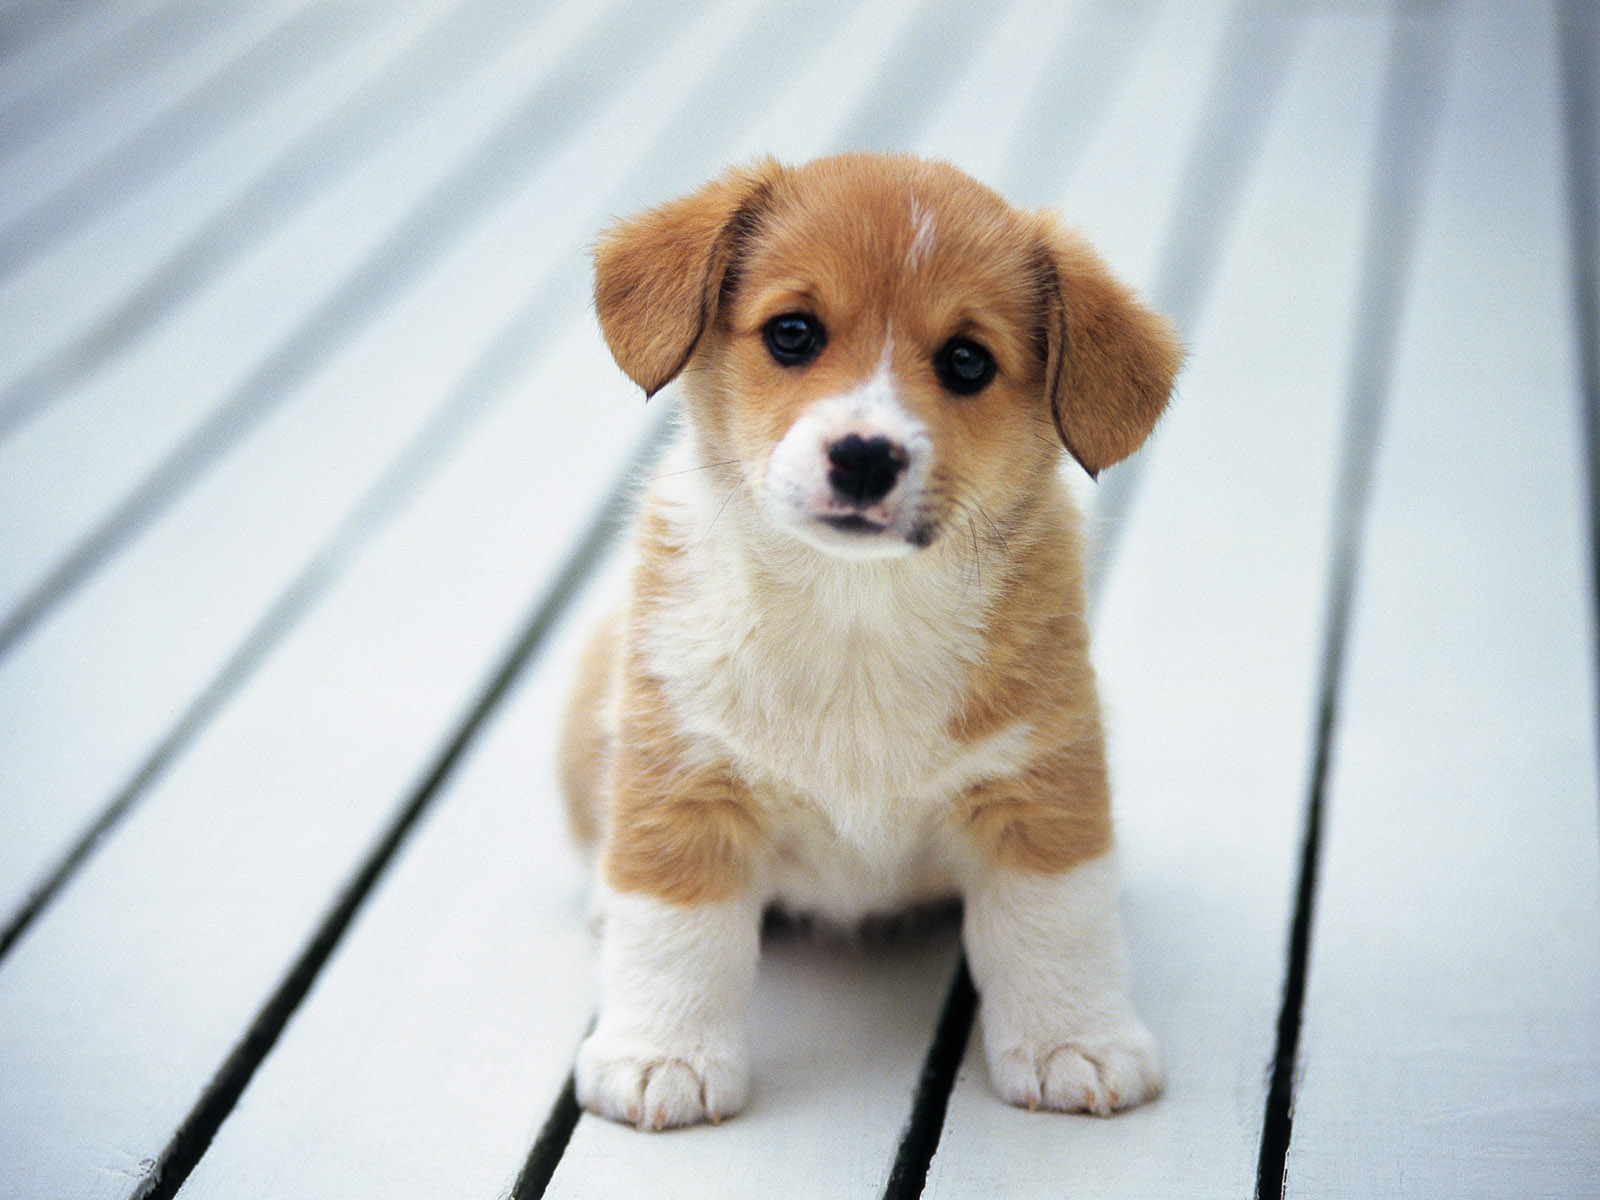

Image  2 : Detected a dog!
You look like a Dogue_de_bordeaux


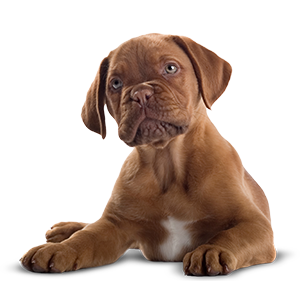

Image  3 : Detected a dog!
You look like a Chihuahua


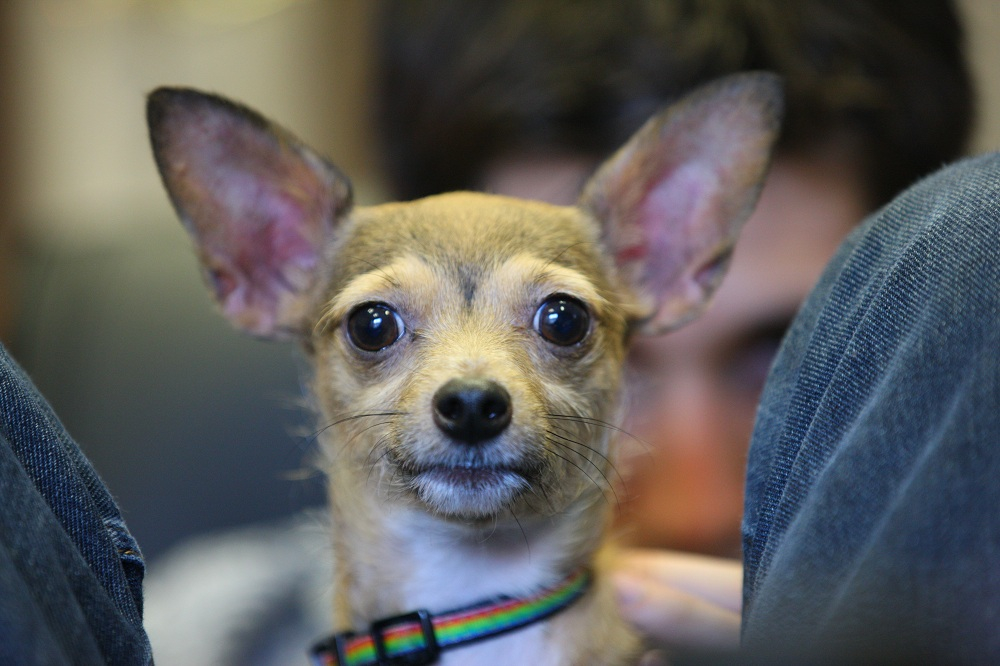

Image  4 : Detected a dog!
You look like a Dachshund


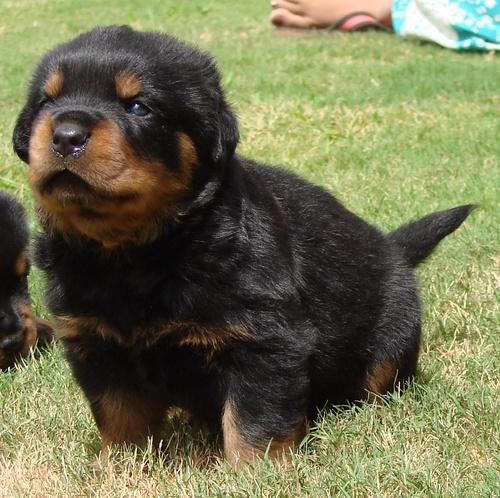

Image  5 : Detected a human face!
You look like a Dachshund


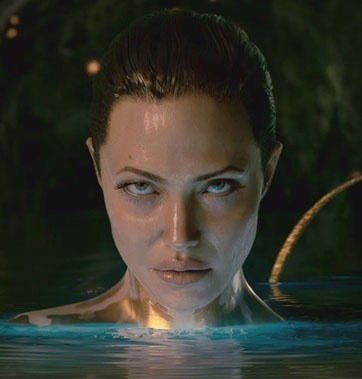

Image  6 : Detected a human face!
You look like a Chinese_crested


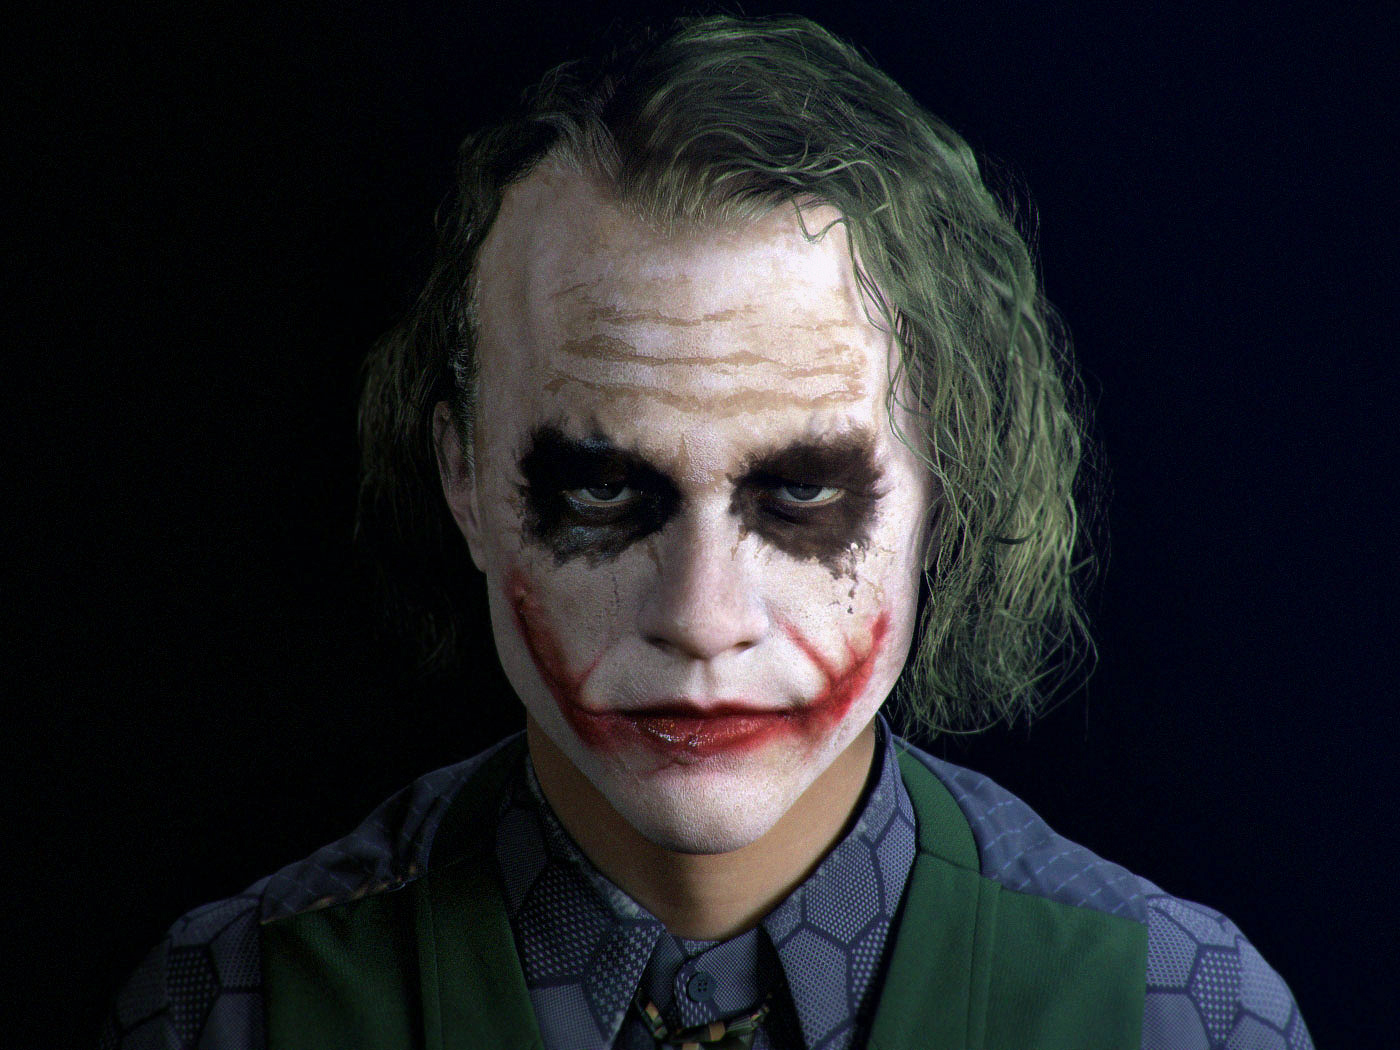

In [32]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

from IPython.display import Image, display

faces=['dog_1.jpg','dog_2.png','dog_3.jpg','dog_4.jpg','face_1.jpeg','face_2.jpg']
#[Retriever,,Dogue_de_bordeaux,rottweiler,angelina,joker]
for i in range(len(faces)):
    path='images/'+faces[i]
    what_breed(path,i)
    display(Image(filename=path, width=150))

The output is better than I've expected. I would suggest doing the following 3 tasks for future work:

1 - Completion of the breed labels: In our particular example as there was no rottweiler breed label in the training set, it approxmated image 4 to a Dashund (via the black/brown color features, shared by the breeds, I suspect). Potentially adding more labels to this work could allow the algorithm to better learn the features that separate dog breeds. This comes with the cost of having to increase the dataset to include a reasonable number of examples for the new labels.

2 - Training for different learning rates and regularisation values, i.e. changing the optimisation procedure, could improve the accuracy of the network.

3 - Archicteture improvement: potentially using the best 2 networks outputs and training the GAP and DENSE layer from these outputs could furhter improve accuracy if the networks have complementary information.

The application of mathing a human face to a dog face is quite interesting. The chinese_crested was selected for the joker due to the high contrast colors in this picture. It is more difficult to figure out the relationship between Angelina Joli's picture and the Dachshund. As an extra I would improve this "task" by adding human percetion into the deep learning network like in this work:
https://richzhang.github.io/PerceptualSimilarity/
(i.e., how would the addition of human bias change the dog-breed network predictions on human faces?)
Obviously this would be a network specific to this task, and not adequate anymore for classifying dog breeds.
